# Put the title here

This notebook follows the order and produce all the figures depicted in the related submission, ""

#### First, we import some libraries

In [6]:
# for arrays
import numpy as np

# for dataframes
import pandas as pd

# plots
import matplotlib.pyplot as plt
# high-level plots
import seaborn as sns

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# machine learning library
# Principal Component Analysis - determine new axis for representing data
from sklearn.decomposition import PCA
# Random Forests -> vote between decision trees
# Gradient boosting -> instead of a vote, upgrade the same tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
# Decision Tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
# To add interactions in linear regressions models
from sklearn.preprocessing import PolynomialFeatures
# Elasticnet is an hybrid method between ridge and Lasso
from sklearn.linear_model import LinearRegression, ElasticNet
# To separate the data into training and test
from sklearn.model_selection import train_test_split
# Simple clustering (iterative steps)
from sklearn.cluster import KMeans
# get interactions of features
from sklearn.preprocessing import PolynomialFeatures


# we use it to interact with the file system
import os
# compute time
from time import time

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# no warning
import warnings
warnings.filterwarnings("ignore")

### Import data

In [7]:
data_dir = "../../data/"
name_systems = ["nodejs", "poppler", "xz", "x264"]

data = dict()
inputs_name = dict()
inputs_count = dict()

inputs_perf = dict()

inputs_perf["x264"] = ["size", "kbs", "fps", "etime", "cpu"]
inputs_perf["xz"] = ["size", "time"]
inputs_perf["poppler"] = ["size", "time"]
inputs_perf["nodejs"] = ["ops"]

inputs_feat = dict()

inputs_feat["x264"] = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", 
                "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", "b_adapt", "direct", 
                "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", "mbtree", "qpmax", "aq-mode"]
inputs_feat["xz"] = ["memory","format","level","depth"]
inputs_feat["poppler"] = ["format","j","jp2","jbig2","ccitt"]
inputs_feat["nodejs"] = ["jitless", "experimental-wasm-modules", "experimental-vm-modules",
                         "preserve-symlinks-main","no-warnings","node-memory-debug"]

inputs_categ = dict()

inputs_categ["x264"] = ['analyse', 'me', 'direct', 'deblock']
inputs_categ["xz"] = ['memory', 'format']
inputs_categ["nodejs"] = []
inputs_categ["poppler"] = ["format"]


for ns in name_systems:
    
    data_path = data_dir+ns+'/'
    
    inputs = os.listdir(data_path)
    inputs.remove('others')

    inputs_name[ns] = inputs
    inputs_count[ns] = len(inputs)
    
    for i in range(len(inputs)):
        loc = data_path+inputs[i]
        data[ns, i] = pd.read_csv(loc)

# RQ1

In [38]:
# We define a function to plot the correlogram
def plot_correlationmatrix_dendogram(ns, dim):
    # ns : name_system
    # dim : dimension
    # output : a plot of an ordered correlogram of the different compile-time options
    
    # number of videos
    inputs_nb = inputs_count[ns]

    corr = [[0 for x in range(inputs_nb)] for y in range(inputs_nb)]

    for i in range(inputs_nb):
        for j in range(inputs_nb):
            # A distribution of bitrates will have a correlaiton of 1 with itself
            if (i == j):
                corr[i][j] = 1
            else:
                # we compute the Spearman correlation between the input video i and the input video j
                corr[i][j] = sc.spearmanr(data[ns, i][dim],
                                          data[ns, j][dim]).correlation

    # we transform our matrix into a dataframe
    df = pd.DataFrame(corr)

    # group the videos, we choose the ward method 
    # single link method (minimum of distance) leads to numerous tiny clusters
    # centroid or average tend to split homogeneous clusters
    # and complete link aggregates unbalanced groups. 
    links = linkage(df, method="ward",)
    order = leaves_list(links)
    
    # Generate a mask for the upper triangle
    # we order the correlation following the aggregation clustering
    mask = np.zeros_like(corr, dtype=np.bool)

    for i in range(inputs_nb):
        for j in range(inputs_nb):    
            if i>j:
                mask[order[i]][order[j]] = True

    g = sns.clustermap(df, cmap="vlag", mask=mask, method="ward",
                   linewidths=0, figsize=(13, 13), #cbar_kws={"ticks":ticks}, 
                   vmin =-1)
    g.ax_heatmap.set_yticklabels([])
    #g.ax_heatmap.set_xticklabels([])
    g.ax_heatmap.tick_params(right=False, bottom=False)
    # abcissa and ordered labels
    g.ax_heatmap.set_xlabel("Inputs", fontsize = 18)
    g.ax_heatmap.set_ylabel("Inputs", fontsize = 18)
    # we save the figure in the result folder
    #plt.savefig("../results/"+ns+"/"+"corr_"+dim+".png")
    # we show the graph
    plt.show()

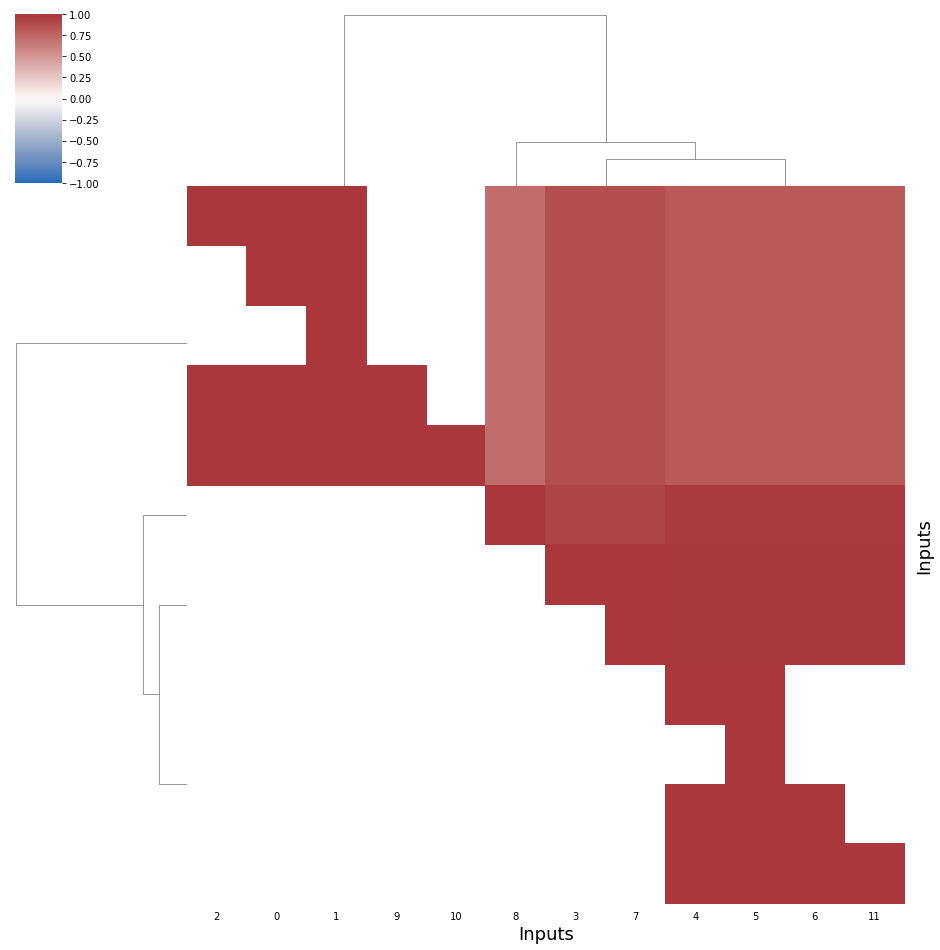

In [39]:
plot_correlationmatrix_dendogram("xz", "size")

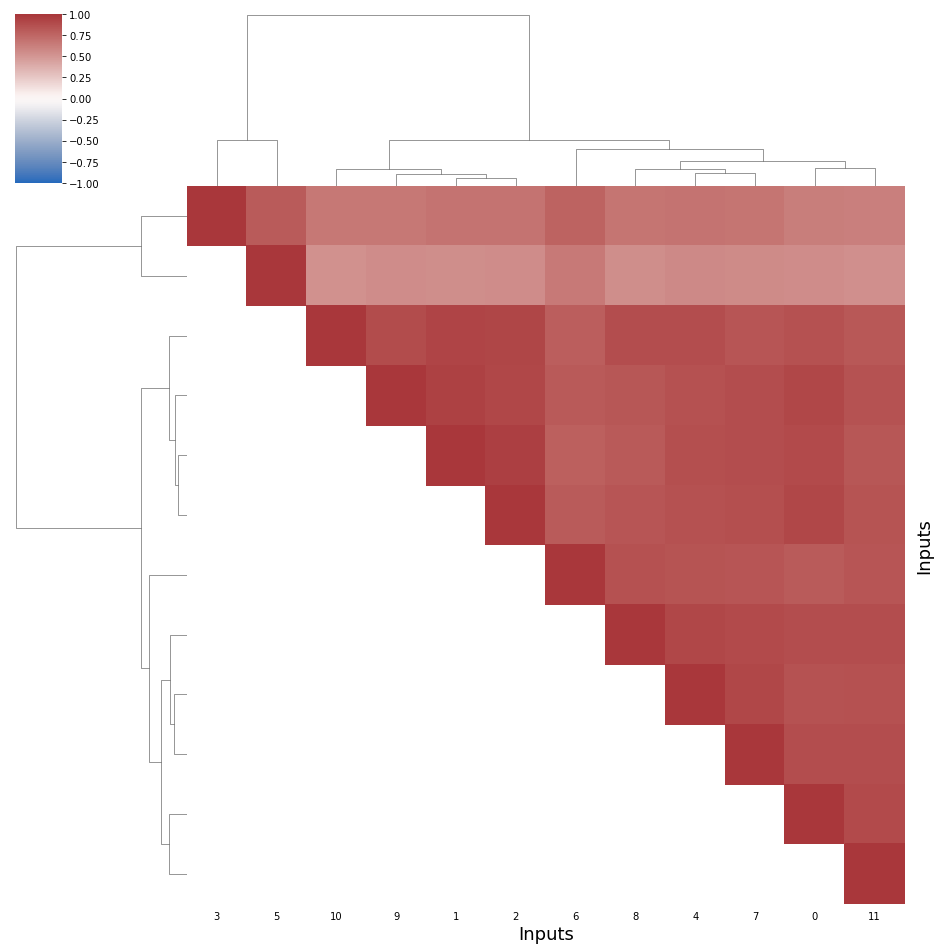

In [40]:
plot_correlationmatrix_dendogram("xz", "time")

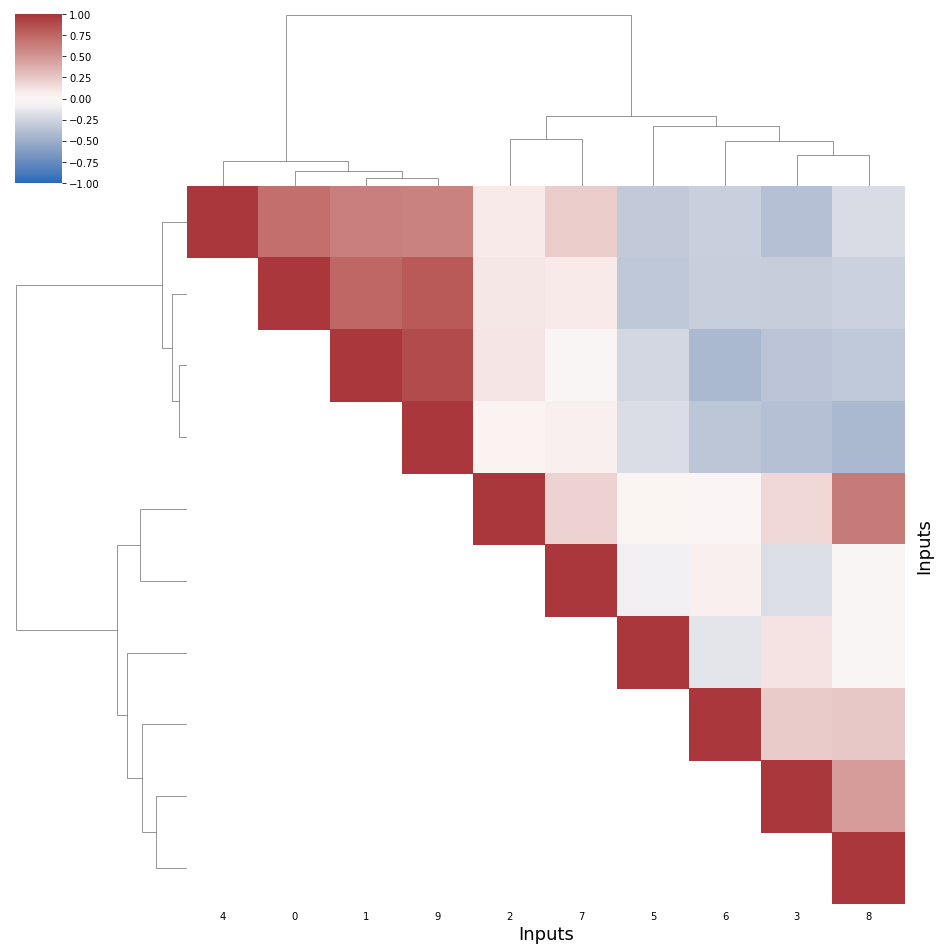

In [41]:
plot_correlationmatrix_dendogram("nodejs", "ops")

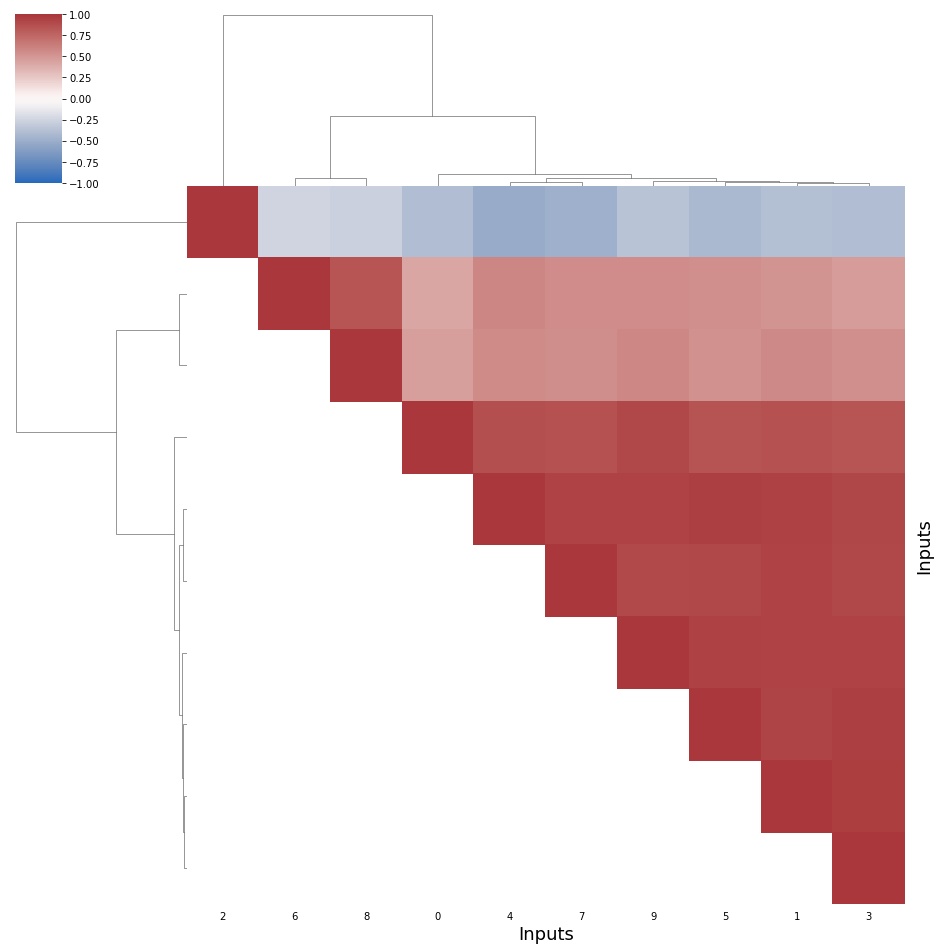

In [43]:
plot_correlationmatrix_dendogram("poppler", "time")

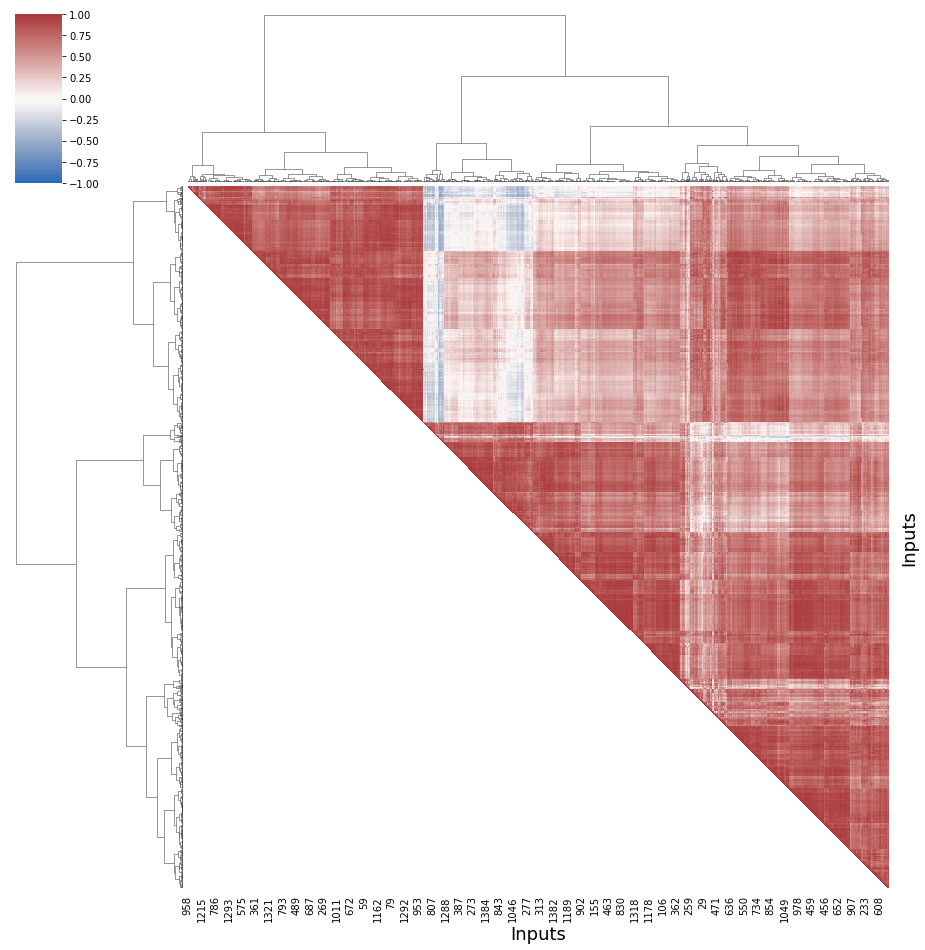

In [45]:
plot_correlationmatrix_dendogram("x264", "kbs")

# RQ2

In [19]:
def compute_importances(ns, dim):
    # input : a list of videos
    # output : a dataframe of feature importances
    
    # the final list of importances
    listImportances = []
    
    features = inputs_feat[ns]
    to_keep = [f for f in features]
    to_keep.append(dim)
    categorial = inputs_categ[ns]

    # for each video of the list
    for id_input in range(inputs_count[ns]):
        
        # we replace missing numbers by 0
        df = data[ns, id_input][to_keep]
        
        if ns == "x264":
            df = df.replace(to_replace = "None", value = '0')
        
        # standardization
        for col in features:
            # we center and reduce the quantitative variables
            # i.e substract the mean, and divide by the standard deviation
            # to avoid the scale of the vars to interfere with the learning process
            if col not in categorial:
                arr_col = np.array(df[col], int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                # if the variable is categorial
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col], int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
        
        # for each video, we train a model
        clf = RandomForestRegressor(n_estimators=20)
        # we use all the configuration options as predicting variables
        X = df.drop([dim], axis=1)
        # and the bitrate distribution of the video as a variable to predict
        y = df[dim]
        # we train the model on all the data (not train-test since we don't use the model)
        clf.fit(X, y)
        
        # we add feature importances to the list
        listImportances.append(clf.feature_importances_)
    
    # final dataframe of feature importances
    res = pd.DataFrame({'features' : features})
    
    # significative numbers p, cs = 10^p
    cs = 100
    
    # we add the feature imps to the dataframe 
    for id_input in range(len(listImportances)):
        res['video_'+str(id_input)] = np.round(cs*listImportances[id_input])/cs
    
    # transpose it
    res = res.set_index('features').transpose()
    
    # return it 
    return res

In [36]:
def compute_coefs(ns, dim):
    # input : a list of videos
    # output : a dataframe of feature importances
    
    # the final list of coefficients
    listCoefs = []
    
    features = inputs_feat[ns]
    to_keep = [f for f in features]
    to_keep.append(dim)
    categorial = inputs_categ[ns]

    # for each video of the list
    for id_input in range(inputs_count[ns]):
        
        # we replace missing numbers by 0
        df = data[ns, id_input][to_keep]
        
        if ns == "x264":
            df = df.replace(to_replace = "None", value = '0')
        
        # standardization
        for col in to_keep:
            # we center and reduce the quantitative variables
            # i.e substract the mean, and divide by the standard deviation
            # to avoid the scale of the vars to interfere with the learning process
            if col not in categorial:
                arr_col = np.array(df[col], int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                # if the variable is categorial
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col], int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
        
        # for each video, we train a model
        lr = LinearRegression()
        # we use all the configuration options as predicting variables
        X = df.drop([dim], axis=1)
        # and the bitrate distribution of the video as a variable to predict
        y = df[dim]
        # we train the model on all the data (not train-test since we don't use the model)
        lr.fit(X, y)
        
        # we add feature importances to the list
        listCoefs.append(lr.coef_)
    
    # final dataframe of feature importances
    res = pd.DataFrame({'features' : features})
    
    # significative numbers p, cs = 10^p
    cs = 100
    
    # we add the feature imps to the dataframe 
    for id_input in range(len(listCoefs)):
        res['video_'+str(id_input)] = np.round(cs*listCoefs[id_input])/cs
    
    # transpose it
    res = res.set_index('features').transpose()
    
    # return it 
    return res

In [37]:
compute_coefs("xz", "time")

features  memory  format  level  depth
video_0     0.00    0.19  -0.93   0.06
video_1    -0.04    0.30  -0.98  -0.16
video_2    -0.02    0.27  -0.99  -0.12
video_3    -0.02    0.17  -0.88   0.08
video_4    -0.02    0.17  -0.88   0.08
video_5    -0.02    0.17  -0.88   0.08
video_6    -0.20    0.04  -0.93   0.02
video_7    -0.02    0.17  -0.88   0.08
video_8    -0.02    0.17  -0.88   0.08
video_9    -0.02    0.18  -0.88   0.04
video_10   -0.04    0.26  -0.93  -0.02
video_11   -0.02    0.17  -0.88   0.08

In [38]:
compute_coefs("xz", "size")

features  memory  format  level  depth
video_0     0.02   -0.17   0.88  -0.08
video_1     0.02   -0.17   0.92  -0.05
video_2     0.02   -0.16   0.93  -0.05
video_3     0.02   -0.17   0.88  -0.08
video_4     0.02   -0.17   0.88  -0.08
video_5     0.02   -0.17   0.88  -0.08
video_6     0.02   -0.17   0.88  -0.08
video_7     0.02   -0.17   0.88  -0.08
video_8     0.02   -0.17   0.88  -0.08
video_9     0.02   -0.16   0.90  -0.07
video_10    0.02   -0.16   0.93  -0.05
video_11    0.02   -0.17   0.88  -0.08

In [39]:
compute_coefs("poppler", "size")

features  format     j  jp2  jbig2  ccitt
video_0     0.25 -0.97 -0.0    0.0   0.00
video_1    -0.13 -0.98 -0.0   -0.0   0.00
video_2     0.00  0.00  0.0    0.0   0.00
video_3    -0.95 -0.32  0.0   -0.0   0.00
video_4    -0.05 -0.99  0.0    0.0   0.00
video_5    -0.22 -0.95  0.0   -0.0  -0.02
video_6    -0.20 -0.96 -0.0    0.0  -0.00
video_7     0.20  0.87 -0.0    0.0  -0.00
video_8    -0.24 -0.94  0.0   -0.0   0.00
video_9    -0.12 -0.98  0.0    0.0   0.00

In [40]:
compute_coefs("poppler", "time")

features  format     j   jp2  jbig2  ccitt
video_0     1.00  0.00 -0.00  -0.00  -0.00
video_1     0.67 -0.56 -0.01   0.01   0.01
video_2     0.00  0.00  0.00   0.00   0.00
video_3     1.00 -0.00  0.00   0.00   0.00
video_4     0.72 -0.56  0.00   0.00   0.00
video_5     0.91 -0.16  0.00   0.00  -0.15
video_6     0.58 -0.58  0.00   0.00   0.00
video_7     0.97 -0.17  0.01  -0.01  -0.01
video_8     0.58 -0.58  0.00   0.00   0.00
video_9     0.76 -0.46  0.00   0.00  -0.00

In [41]:
compute_coefs("nodejs", "ops")

features  jitless  experimental-wasm-modules  experimental-vm-modules  \
video_0      0.00                       0.00                     0.00   
video_1      0.00                       0.00                     0.00   
video_2     -0.16                       0.08                    -0.06   
video_3      0.31                       0.16                    -0.11   
video_4     -0.99                      -0.03                    -0.01   
video_5      0.11                      -0.20                     0.07   
video_6      0.00                       0.00                     0.00   
video_7      0.22                       0.18                    -0.17   
video_8      0.00                       0.00                     0.00   
video_9      0.00                       0.00                     0.00   

features  preserve-symlinks-main  no-warnings  node-memory-debug  
video_0                     0.00         0.00               0.00  
video_1                     0.00         0.00               0.00  
video_2                    -0.19         0.03               0.09  
video_3                    -0.15        -0.20              -0.08  
video_4                    -0.03        -0.02               0.02  
video_5                     0.21         0.04              -0.25  
video_6                     0.00         0.00               0.00  
video_7                    -0.24         0.22              -0.09  
video_8                     0.00         0.00               0.00  
video_9                     0.00         0.00               0.00

In [42]:
def boxplot_imp(res, xlim = None, name = None, xname='Feature importances'):
    
    listImp = [(np.abs(np.percentile(res[col],75)-np.percentile(res[col],25)),res[col], col) 
               for col in res.columns]
    listImp.sort(key=lambda tup: tup[2], reverse=True)

    # see figures 2a and 2b
    red_square = dict(markerfacecolor='r', marker='s')
    plt.figure(figsize=(15,8))
    plt.grid()
    plt.boxplot([l[1] for l in listImp], flierprops=red_square, 
              vert=False, patch_artist=True, #widths=0.25,
              boxprops=dict(facecolor=(0,0,1,0.5),linewidth=1,edgecolor='k'),
              whiskerprops = dict(linestyle='-.',linewidth=1.0, color='black'))
    plt.xlabel(xname, size=13)
    if xlim:
        plt.xlim(xlim)
    plt.yticks(range(1, len(listImp) + 1), [l[2] for l in listImp])
    if name:
        plt.savefig(name)
    plt.show()

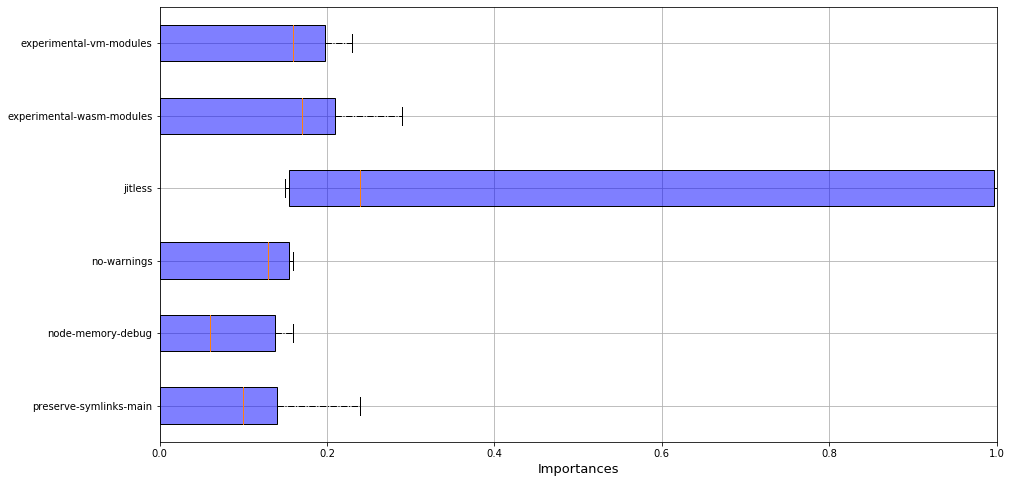

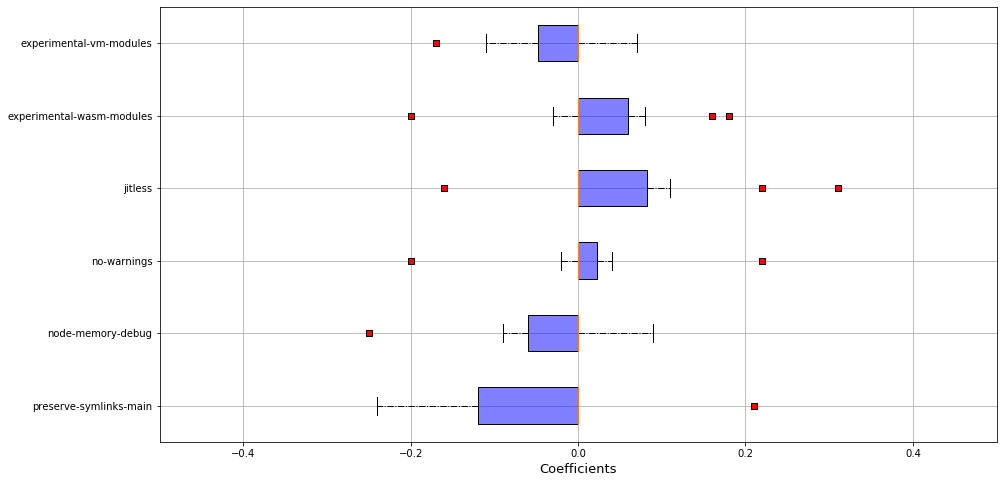

In [49]:
boxplot_imp(compute_importances("nodejs", "ops"), xlim =[0,1], xname='Importances')
boxplot_imp(compute_coefs("nodejs", "ops"), xlim =[-0.5,0.5], xname='Coefficients')

In [ ]:
boxplot_imp(compute_importances("nodejs", "ops"), xlim =[0,1], xname='Importances')
boxplot_imp(compute_coefs("nodejs", "ops"), xlim =[-0.5,0.5], xname='Coefficients')

# RQ1.1

### Compute some boxplot of runtime performances

#### Figure 2a

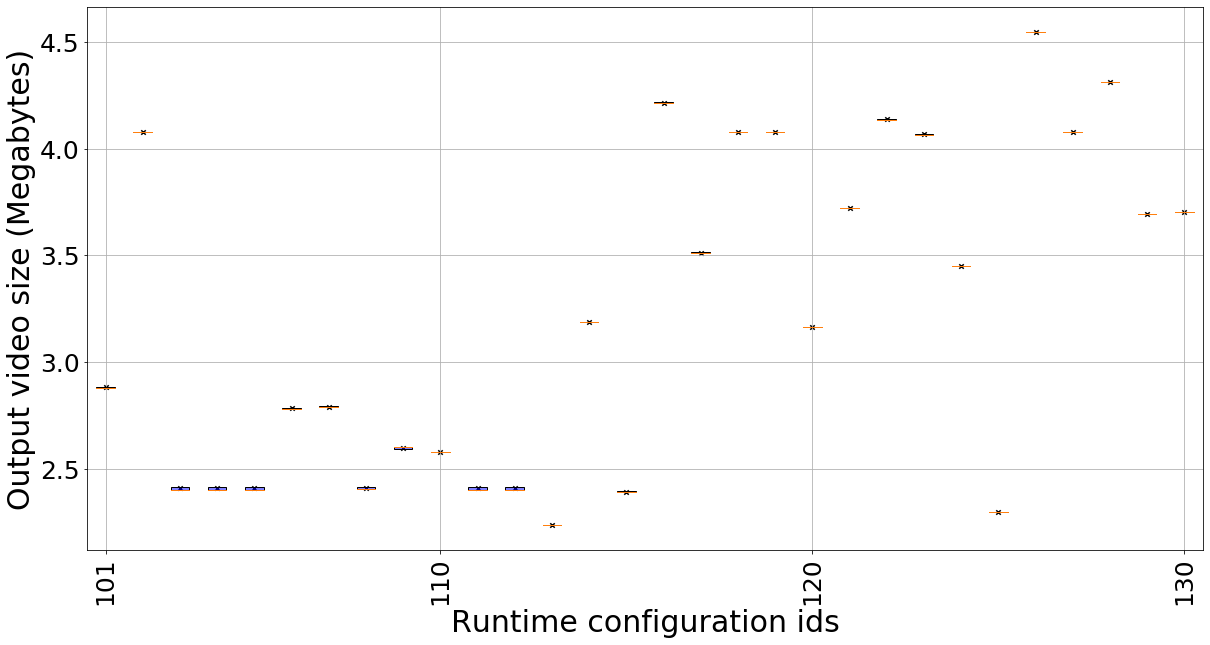

In [3]:
ns ="x264"
dim = "size"
inputs_index = 7

listDim = []
for i in range(len(list_dir)):
    df = data[ns, list_dir[i], inputs_index]
    listDim.append(df[dim]/1e6)

print()

transposed_listDim = []
for i in range(len(listDim[0])):
    transposed_listDim.append([listDim[j][i] for j in range(len(listDim))])


red_square = dict(markerfacecolor='r', marker='s')
plt.figure(figsize=(20,10))
plt.grid()
plt.scatter([k+1 for k in range(30)], [np.mean(l) for l in transposed_listDim[100:130]],
           marker="x", color = "black", alpha = 1, s = 20)
plt.boxplot(transposed_listDim[100:130], flierprops=red_square, 
          vert=True, patch_artist=True, #widths=0.25,
          boxprops=dict(facecolor=(0,0,1,0.5),linewidth=1,edgecolor='k'),
          whiskerprops = dict(linestyle='-.',linewidth=1.0, color='black'))

plt.xticks([k for k in range(1, 31) if k%10==0 or k==1],[k for k in range(101,131) if k%10==0 or k==101], 
           rotation='vertical', size = 25)

#plt.title("x264, Sports video, "+dim, size = 25)
plt.ylabel("Output video size (Megabytes)", size = 30)
plt.xlabel("Runtime configuration ids", size=30)
plt.yticks(size=25)
plt.savefig("../results/boxplot_"+ns+"_"+dim+".png")
plt.show()

In [4]:
count_fail = 0
remaining_pvals = []
for i in range(len(listDim)):
    for j in range(len(listDim)):
        try:
            if i!=j:
                remaining_pvals.append(stats.wilcoxon(listDim[i], listDim[j])[1])
        except:
            count_fail+=1
print(count_fail/(len(listDim)**2-len(listDim))*100, "% failures")

46.666666666666664 % failures


In [5]:
np.mean([np.percentile(distr,75)-np.percentile(distr,25) for distr in transposed_listDim])

0.0023844975124377747

In [6]:
np.mean(transposed_listDim)

3.011037094195688

In [7]:
ns ="xz"
dim = "size"
inputs_index = 8

listDim = []
for i in range(len(list_dir)):
    df = data[ns, list_dir[i], inputs_index]
    listDim.append(df[dim]/1e6)

transposed_listDim = []
for i in range(len(listDim[0])):
    transposed_listDim.append([listDim[j][i] for j in range(len(listDim))])
    
np.mean([np.percentile(distr,75)-np.percentile(distr,25) for distr in transposed_listDim])

2.6666666666989396e-06

In [8]:
np.mean(transposed_listDim)

2.8506282

In [9]:
ns ="poppler"
dim = "size"
inputs_index = 8

listDim = []
for i in range(len(list_dir)):
    df = data[ns, list_dir[i], inputs_index]
    listDim.append(df[dim]/1e6)

transposed_listDim = []
for i in range(len(listDim[0])):
    transposed_listDim.append([listDim[j][i] for j in range(len(listDim))])
    
np.mean([np.percentile(distr,75)-np.percentile(distr,25) for distr in transposed_listDim])

1.6218750000171478e-05

In [10]:
np.mean(transposed_listDim)

2.363521454166667

#### Figure 2b

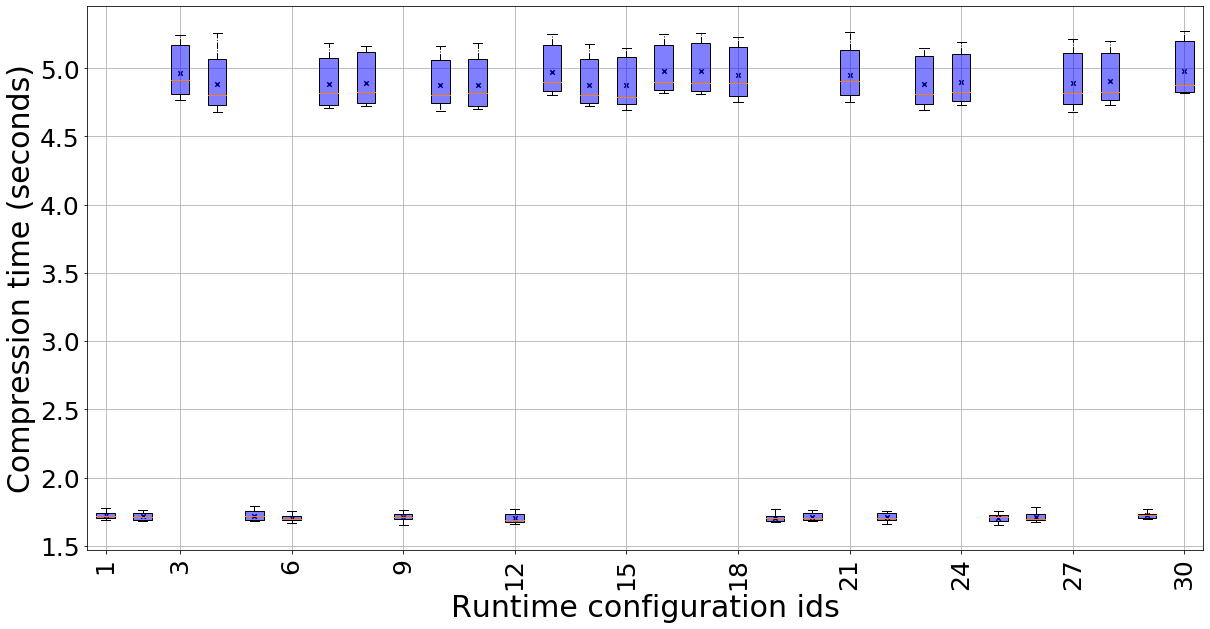

In [11]:
ns ="xz"
dim = "time"
inputs_index = 4

listDim = []
for i in range(len(list_dir)):
    df = data[ns, list_dir[i], inputs_index]
    listDim.append(df[dim])

print()

transposed_listDim = []
for i in range(len(listDim[0])):
    transposed_listDim.append([listDim[j][i] for j in range(len(listDim))])

plt.figure(figsize=(20,10))

#plt.title("xz, Reymont file, "+dim, size = 25)
plt.ylabel("Compression time (seconds)", size = 30)
plt.xlabel("Runtime configuration ids", size = 30)

plt.grid()
plt.scatter([k+1 for k in range(len(transposed_listDim))], [np.mean(l) for l in transposed_listDim],
           marker="x", color = "black", alpha = 1, s = 20)
plt.boxplot(transposed_listDim, flierprops=red_square, 
          vert=True, patch_artist=True, #widths=0.25,
          boxprops=dict(facecolor=(0,0,1,0.5),linewidth=1,edgecolor='k'),
          whiskerprops = dict(linestyle='-.',linewidth=1.0, color='black'))
plt.xticks([k for k in range(1,31) if k%3==0 or k==1],[k for k in range(1,31) if k%3==0 or k ==1], 
           rotation='vertical', size =25)
plt.yticks(size=25)
plt.savefig("../results/boxplot_"+ns+"_"+dim+".png")
plt.show()

In [12]:
stats.wilcoxon(listDim[3], listDim[10])

WilcoxonResult(statistic=14.0, pvalue=6.9798846122882135e-06)

In [13]:
ns ="poppler"
dim = "time"
inputs_index = 8

listDim = []
for i in range(len(list_dir)):
    df = data[ns, list_dir[i], inputs_index]
    listDim.append(df[dim])

transposed_listDim = []
for i in range(len(listDim[0])):
    transposed_listDim.append([listDim[j][i] for j in range(len(listDim))])
    
np.mean([np.percentile(distr,75)-np.percentile(distr,25) for distr in transposed_listDim])

0.02884375

In [14]:
np.mean(transposed_listDim)

2.6650833333333335

In [15]:
ns ="xz"
dim = "time"
inputs_index = 4

listDim = []
for i in range(len(list_dir)):
    df = data[ns, list_dir[i], inputs_index]
    listDim.append(df[dim])

transposed_listDim = []
for i in range(len(listDim[0])):
    transposed_listDim.append([listDim[j][i] for j in range(len(listDim))])
    
[np.percentile(distr,75)-np.percentile(distr,25) for distr in transposed_listDim][7]

0.37100000000000044

In [16]:
np.mean(transposed_listDim)

3.63616

#### Figure 2c

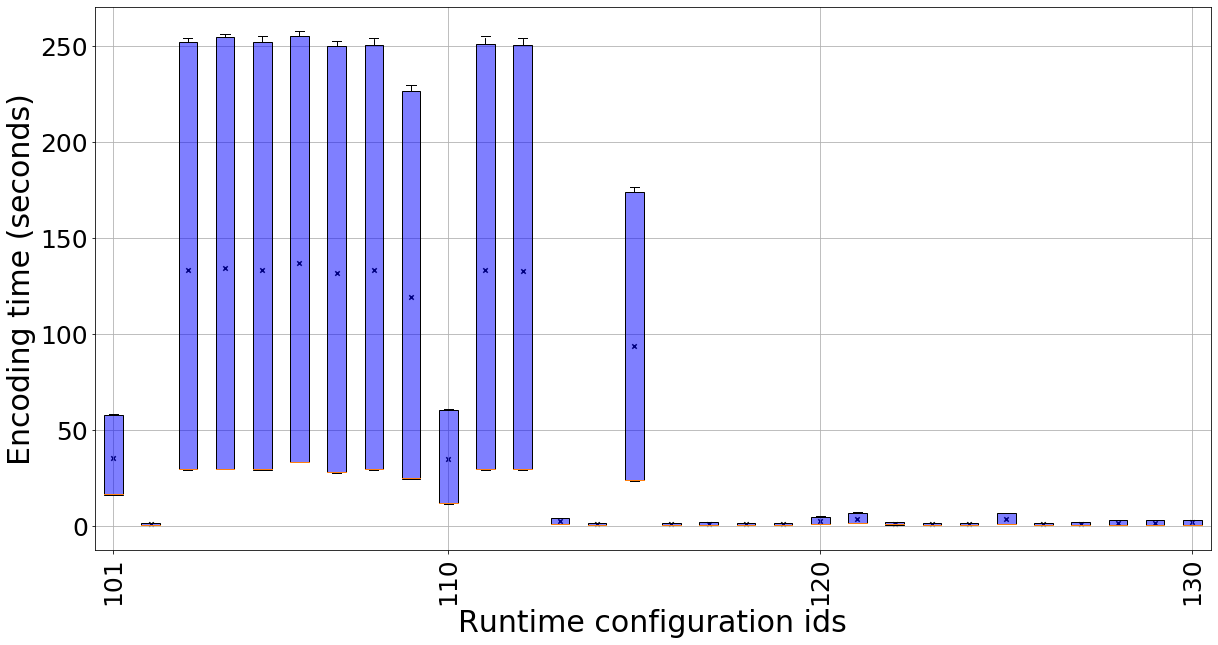

In [17]:
ns ="x264"
dim = "time"
inputs_index = 3

listDim = []
for i in range(len(list_dir)):
    df = data[ns, list_dir[i], inputs_index]
    listDim.append(df[dim])

print()

transposed_listDim = []
for i in range(len(listDim[0])):
    transposed_listDim.append([listDim[j][i] for j in range(len(listDim))])

plt.figure(figsize=(20,10))

#plt.title("x264, Music video, "+dim, size = 30)
plt.ylabel("Encoding time (seconds)", size = 30)
plt.xlabel("Runtime configuration ids", size=30)

plt.grid()
plt.scatter([k+1 for k in range(30)], [np.mean(l) for l in transposed_listDim[100:130]],
           marker="x", color = "black", alpha = 1, s = 20)
plt.boxplot(transposed_listDim[100:130], flierprops=red_square, 
          vert=True, patch_artist=True, #widths=0.25,
          boxprops=dict(facecolor=(0,0,1,0.5),linewidth=1,edgecolor='k'),
          whiskerprops = dict(linestyle='-.',linewidth=1.0, color='black'))

plt.xticks([k for k in range(1, 31) if k%10==0 or k==1],[k for k in range(101,131) if k%10==0 or k==101], 
           rotation='vertical', size = 25)
plt.yticks(size=25)
plt.savefig("../results/boxplot_"+ns+"_"+dim+".png")
plt.show()

In [18]:
[np.percentile(distr,75)-np.percentile(distr,25) for distr in transposed_listDim][100:130]

[41.487,
 1.0354999999999999,
 222.576,
 225.0385,
 222.44150000000002,
 221.7275,
 221.9965,
 221.064,
 201.67749999999998,
 48.3555,
 221.7025,
 220.8805,
 3.377500000000001,
 1.3170000000000002,
 149.8705,
 1.0554999999999999,
 1.5390000000000001,
 1.0150000000000001,
 1.036,
 4.1114999999999995,
 5.3535,
 1.0915,
 1.1985000000000001,
 1.1855000000000002,
 5.6355,
 1.2109999999999999,
 1.6324999999999998,
 2.3255000000000003,
 2.1975,
 2.5575]

In [19]:
[np.mean(distr) for distr in transposed_listDim][100:130]

[35.64046666666666,
 0.8647333333333334,
 133.57020000000003,
 134.48086666666666,
 133.32726666666667,
 137.03093333333337,
 131.67120000000003,
 133.08426666666668,
 119.13879999999999,
 34.69179999999999,
 133.0613333333333,
 132.88333333333335,
 2.5179333333333327,
 1.0794666666666666,
 94.00446666666667,
 0.8967333333333334,
 1.1708666666666667,
 0.8457333333333333,
 0.8632666666666666,
 2.823066666666666,
 3.917400000000001,
 1.3214666666666668,
 0.9680666666666667,
 0.9881333333333334,
 3.7637333333333336,
 0.9596,
 1.1832,
 1.7437999999999998,
 1.7738666666666665,
 1.9347999999999996]

#### Figure 2d

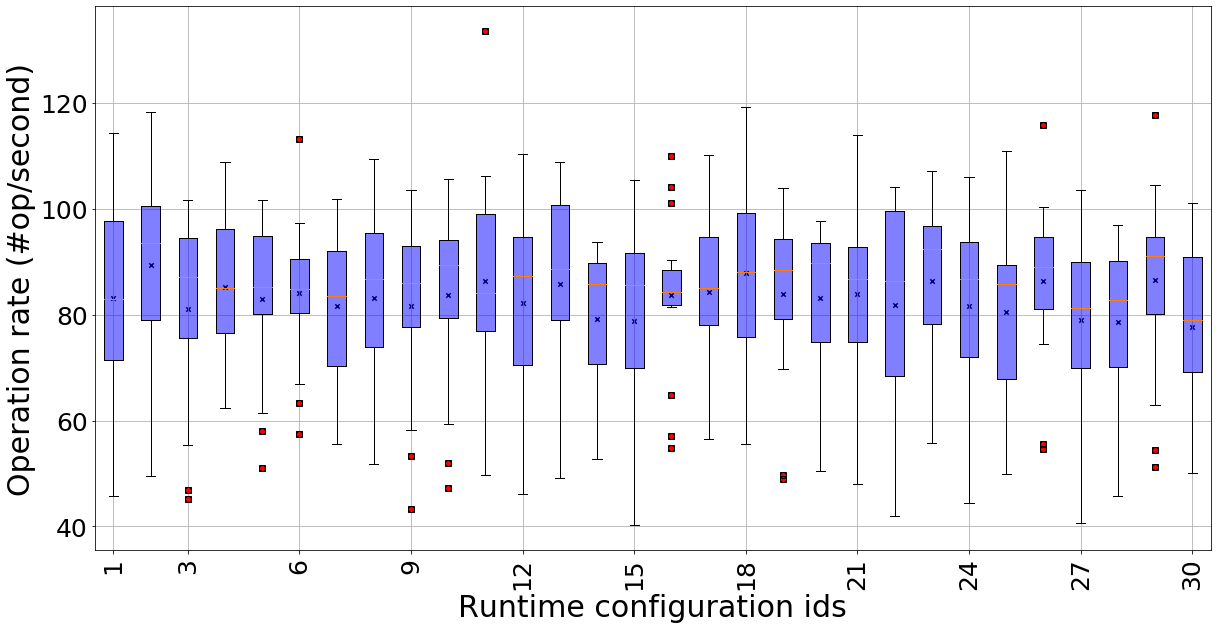

In [20]:
ns ="nodejs"
dim = "ops"
inputs_index = 2

listDim = []
for i in range(len(list_dir)):
    df = data[ns, list_dir[i], inputs_index]
    listDim.append(df[dim])

print()

transposed_listDim = []
for i in range(len(listDim[0])):
    transposed_listDim.append([listDim[j][i] for j in range(len(listDim))])

plt.figure(figsize=(20,10))

#plt.title("nodejs, fsfile script, operation rate", size = 25)
plt.ylabel("Operation rate (#op/second)", size = 30)
plt.xlabel("Runtime configuration ids", size=30)

plt.grid()
plt.scatter([k+1 for k in range(len(transposed_listDim))], [np.mean(l) for l in transposed_listDim],
           marker="x", color = "black", alpha = 1, s = 20)
plt.boxplot(transposed_listDim, flierprops=red_square, 
          vert=True, patch_artist=True, #widths=0.25,
          boxprops=dict(facecolor=(0,0,1,0.5),linewidth=1,edgecolor='k'),
          whiskerprops = dict(linestyle='-.',linewidth=1.0, color='black'))
plt.boxplot(transposed_listDim)
plt.xticks([k for k in range(1,31) if k%3==0 or k==1],[k for k in range(1,31) if k%3==0 or k ==1], 
           rotation='vertical', size =25)
plt.yticks(size=25)
plt.savefig("../results/boxplot_"+ns+"_"+dim+".png")
plt.show()

In [21]:
np.mean([np.percentile(distr,75)-np.percentile(distr,25) for distr in transposed_listDim])

19.165875094818382

In [22]:
np.mean(transposed_listDim)

83.13399220964308

In [23]:
stats.wilcoxon(listDim[1], listDim[3])

WilcoxonResult(statistic=216.0, pvalue=0.7343252914391281)

runtime dist of compile-time options 1 and 3 are not significantly different 

In [24]:
stats.wilcoxon(listDim[1], listDim[11])

WilcoxonResult(statistic=9.0, pvalue=4.285685869189864e-06)

In [27]:
stats.wilcoxon(listDim[4], listDim[8])

WilcoxonResult(statistic=20.0, pvalue=1.2380795614564472e-05)

runtime dist of compile-time options 1 and 11 are significantly different 

# RQ1.2

### Compute the ratio between runtime performances of the compile-time options and the default configuration

#### Table 2a - Average and standard deviation ratios

In [21]:
def get_ratios(name_system, input_index, dim):
    
    list_inputs = inputs_name[name_system]
    
    nb_ctime_configs = len(os.listdir("../data/"+name_system))-2
    
    ratios = []
    
    for i in range(1, nb_ctime_configs+1):
        
        df = data[name_system, str(i), input_index]
        df_def = default_data[name_system, input_index]
        
        ratios.append(df[dim]/df_def[dim])
    
    return (np.round(np.mean(ratios),2), np.round(np.std(ratios),2))

In [22]:
get_ratios("x264", 0, "size")

(1.0, 0.0)

In [23]:
results = dict()

perfs = dict()
perfs["x264"] = ["time", "fps"]
perfs["xz"] = ["time"]
perfs["poppler"] = ["time"]
perfs["nodejs"] = ["ops"]

for ns in name_systems:
    if ns in perfs:
        for p in perfs[ns]:                
            nb_inputs = len(inputs_name[ns])
            for input_index in range(nb_inputs):
                results[ns, input_index+1, p] = get_ratios(ns, input_index, p)

print("\\begin{tabular}{|c|c|c|c|c|c|}")
perfs = sorted(pd.Series([(k[0], k[2]) for k in results.keys()]).unique())
print("\\hline")
print("System")
print("& nodejs")
print("& poppler")
print("& \\multicolumn{2}{|c|}{x264}")
print("& xz")
#for i in range(len(perfs)):
#    print("& "+perfs[i][0])
print("\\\\ \\hline")
print("Perf. $\mathcal{P}$")
for i in range(len(perfs)):
    print("& "+perfs[i][1])
print("\\\\ \\hline")
for i in range(1, 13):
    print("$\mathcal{I}$\\#"+str(i))
    for j in range(len(perfs)):
        if i <= len(inputs_name[perfs[j][0]]):
            if results[perfs[j][0], i, perfs[j][1]]:
                mean_ratios, std_ratios = results[perfs[j][0], i, perfs[j][1]]
                print("& "+str(mean_ratios)+" $\pm$ "+str(std_ratios))
        else:
            print("& \\cellcolor[HTML]{C0C0C0}")
    print("\\\\ \\hline")
print("\\end{tabular}")

\begin{tabular}{|c|c|c|c|c|c|}
\hline
System
& nodejs
& poppler
& \multicolumn{2}{|c|}{x264}
& xz
\\ \hline
Perf. $\mathcal{P}$
& ops
& time
& fps
& time
& time
\\ \hline
$\mathcal{I}$\#1
& 0.8 $\pm$ 0.34
& 1.0 $\pm$ 0.02
& 0.59 $\pm$ 0.4
& 3.33 $\pm$ 2.4
& 1.01 $\pm$ 0.03
\\ \hline
$\mathcal{I}$\#2
& 0.79 $\pm$ 0.36
& 1.0 $\pm$ 0.01
& 0.59 $\pm$ 0.39
& 3.5 $\pm$ 2.53
& 1.16 $\pm$ 0.48
\\ \hline
$\mathcal{I}$\#3
& 0.86 $\pm$ 0.2
& 1.0 $\pm$ 0.01
& 0.59 $\pm$ 0.4
& 3.5 $\pm$ 2.57
& 1.11 $\pm$ 0.32
\\ \hline
$\mathcal{I}$\#4
& 1.01 $\pm$ 0.11
& 1.0 $\pm$ 0.01
& 0.6 $\pm$ 0.39
& 3.26 $\pm$ 2.37
& 1.01 $\pm$ 0.02
\\ \hline
$\mathcal{I}$\#5
& 0.73 $\pm$ 0.41
& 1.0 $\pm$ 0.01
& 0.59 $\pm$ 0.4
& 3.53 $\pm$ 2.62
& 1.02 $\pm$ 0.03
\\ \hline
$\mathcal{I}$\#6
& 1.05 $\pm$ 0.21
& 1.0 $\pm$ 0.02
& 0.6 $\pm$ 0.4
& 3.35 $\pm$ 2.49
& 1.01 $\pm$ 0.02
\\ \hline
$\mathcal{I}$\#7
& 0.98 $\pm$ 0.01
& 1.0 $\pm$ 0.07
& 0.58 $\pm$ 0.4
& 3.75 $\pm$ 2.8
& 1.01 $\pm$ 0.03
\\ \hline
$\mathcal{I}$\#8
& 0.84 $\pm$ 

#### Table 2b - Best ratios (minimal time, and max fps or operation per second)

In [24]:
def get_ratios_indic(name_system, input_index, dim, indic):
    
    list_inputs = inputs_name[name_system]
    
    nb_ctime_configs = len(os.listdir("../data/"+name_system))-2
    
    ratios = []
    
    for i in range(1, nb_ctime_configs+1):
        
        df = data[name_system, str(i), input_index]
        df_def = default_data[name_system, input_index]
        
        ratios.append(df[dim]/df_def[dim])
    
    if indic == "max":
        res = np.round(np.max(ratios), 2)
    if indic == "min":
        res = np.round(np.min(ratios), 2)
    
    return res

results = dict()

perfs = dict()
perfs["x264"] = ["time", "fps"]
perfs["xz"] = ["time"]
perfs["poppler"] = ["time"]
perfs["nodejs"] = ["ops"]

for ns in name_systems:
    if ns in perfs:
        for p in perfs[ns]:
            nb_inputs = len(inputs_name[ns])
            if p == "time":
                for input_index in range(nb_inputs):
                    results[ns, input_index+1, p] = get_ratios_indic(ns, input_index, p, "min")
            else:
                for input_index in range(nb_inputs):
                    results[ns, input_index+1, p] = get_ratios_indic(ns, input_index, p, "max")
                    
print("\\begin{tabular}{|c|c|c|c|c|c|}")
perfs = sorted(pd.Series([(k[0], k[2]) for k in results.keys()]).unique())
print("\\hline")
print("System")
print("& nodejs")
print("& poppler")
print("& \\multicolumn{2}{|c|}{x264}")
print("& xz")
#for i in range(len(perfs)):
#    print("& "+perfs[i][0])
print("\\\\ \\hline")
print("Perf. $\mathcal{P}$")
for i in range(len(perfs)):
    print("& "+perfs[i][1])
print("\\\\ \\hline")
for i in range(1, 13):
    print("$\mathcal{I}$\\#"+str(i))
    for j in range(len(perfs)):
        if i <= len(inputs_name[perfs[j][0]]):
            if results[perfs[j][0], i, perfs[j][1]]:
                print("& "+str(results[perfs[j][0], i, perfs[j][1]]))
        else:
            print("& \\cellcolor[HTML]{C0C0C0}")
    print("\\\\ \\hline")
print("\\end{tabular}")

\begin{tabular}{|c|c|c|c|c|c|}
\hline
System
& nodejs
& poppler
& \multicolumn{2}{|c|}{x264}
& xz
\\ \hline
Perf. $\mathcal{P}$
& ops
& time
& fps
& time
& time
\\ \hline
$\mathcal{I}$\#1
& 1.06
& 0.95
& 1.12
& 0.94
& 0.95
\\ \hline
$\mathcal{I}$\#2
& 1.08
& 0.98
& 1.14
& 0.93
& 0.98
\\ \hline
$\mathcal{I}$\#3
& 1.48
& 0.98
& 1.12
& 0.95
& 0.97
\\ \hline
$\mathcal{I}$\#4
& 1.68
& 0.97
& 1.27
& 0.83
& 0.96
\\ \hline
$\mathcal{I}$\#5
& 1.18
& 0.97
& 1.1
& 0.94
& 0.96
\\ \hline
$\mathcal{I}$\#6
& 2.3
& 0.95
& 1.68
& 0.51
& 0.97
\\ \hline
$\mathcal{I}$\#7
& 1.01
& 0.84
& 1.35
& 0.94
& 0.94
\\ \hline
$\mathcal{I}$\#8
& 2.28
& 0.97
& 1.12
& 0.93
& 0.97
\\ \hline
$\mathcal{I}$\#9
& 1.04
& 0.95
& \cellcolor[HTML]{C0C0C0}
& \cellcolor[HTML]{C0C0C0}
& 0.97
\\ \hline
$\mathcal{I}$\#10
& 1.09
& 0.92
& \cellcolor[HTML]{C0C0C0}
& \cellcolor[HTML]{C0C0C0}
& 0.97
\\ \hline
$\mathcal{I}$\#11
& \cellcolor[HTML]{C0C0C0}
& \cellcolor[HTML]{C0C0C0}
& \cellcolor[HTML]{C0C0C0}
& \cellcolor[HTML]{C0C0C0}
& 0.

# RQ2

# RQ2.1

### Spearman correlogram

In [25]:
# We define a function to plot the correlogram
def plot_correlationmatrix_dendogram(ns, dim):
    # ns : name_system
    # dim : dimension
    # output : a plot of an ordered correlogram of the different compile-time options
    
    # number of videos
    nb_ctime = len(os.listdir(data_dir+ns))-2
    
    for input_index in range(len(inputs_name[ns])):
        
        # matrix of coorelations
        corr = [[0 for x in range(nb_ctime)] for y in range(nb_ctime)]

        for i in range(nb_ctime):
            for j in range(nb_ctime):
                # A distribution of bitrates will have a correlaiton of 1 with itself
                if (i == j):
                    corr[i][j] = 1
                else:
                    # we compute the Spearman correlation between the input video i and the input video j
                    corr[i][j] = sc.spearmanr(data[ns, str(i+1), input_index][dim],
                                              data[ns, str(j+1), input_index][dim]).correlation
                    #corr[i][j] = np.corrcoef(data[ns, str(i+1), input_index][dim],
                    #                                data[ns, str(j+1), input_index][dim])[0,1]
                    

        # we transform our matrix into a dataframe
        df = pd.DataFrame(corr)

        # group the videos, we choose the ward method 
        # single link method (minimum of distance) leads to numerous tiny clusters
        # centroid or average tend to split homogeneous clusters
        # and complete link aggregates unbalanced groups. 
        links = linkage(df, method="ward",)
        order = leaves_list(links)

        # we order the correlation following the aggregation clustering
        mask = np.zeros_like(corr, dtype=np.bool)

        for i in range(nb_ctime):
            for j in range(nb_ctime):
                # Generate a mask for the upper triangle
                if i>j:
                    mask[order[i]][order[j]] = True
        
        g = sns.clustermap(df, cmap="vlag", mask=mask, method="ward",
                       linewidths=0, figsize=(13, 13), #cbar_kws={"ticks":ticks}, 
                       vmin =-1)
        g.ax_heatmap.set_yticklabels([])
        #g.ax_heatmap.set_xticklabels([])
        g.ax_heatmap.tick_params(right=False, bottom=False)
        # abcissa and ordered labels
        g.ax_heatmap.set_xlabel("Compile-time options", fontsize = 18)
        g.ax_heatmap.set_ylabel("Compile-time options", fontsize = 18)
        # we save the figure in the result folder
        plt.savefig("../results/"+ns+"/"+"corr_"+str(input_index+1)+"_"+dim+".png")
        # we show the graph
        plt.show()

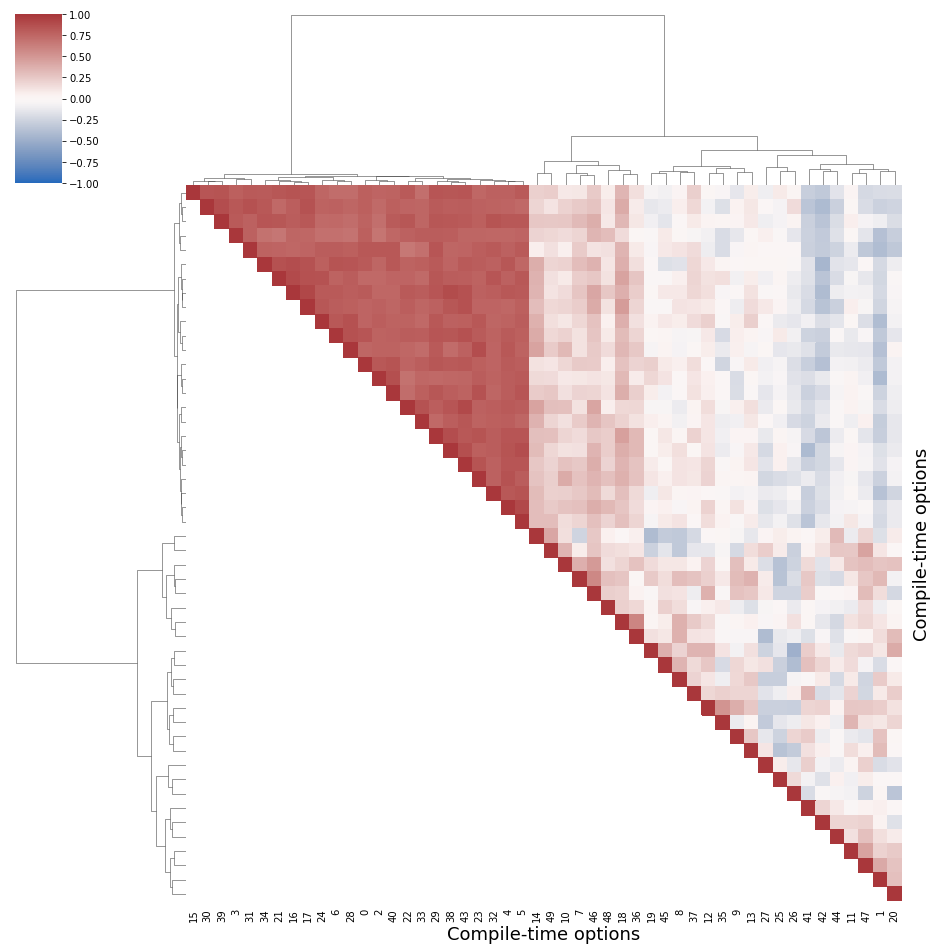

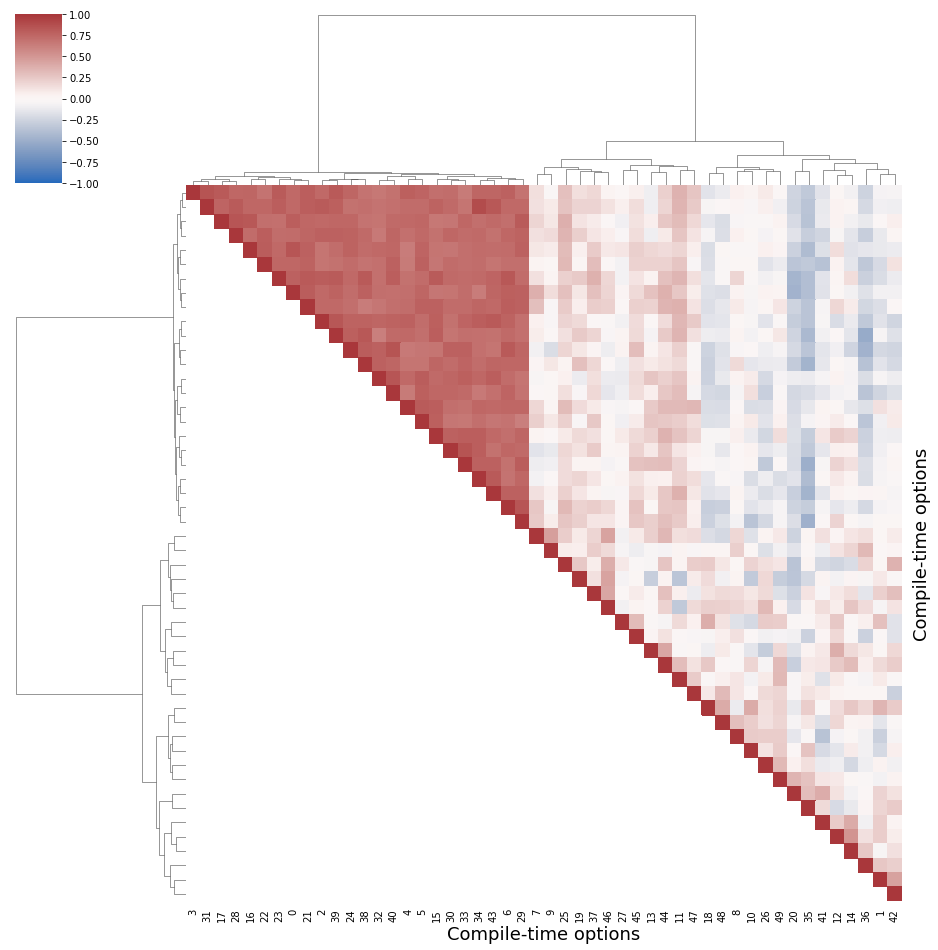

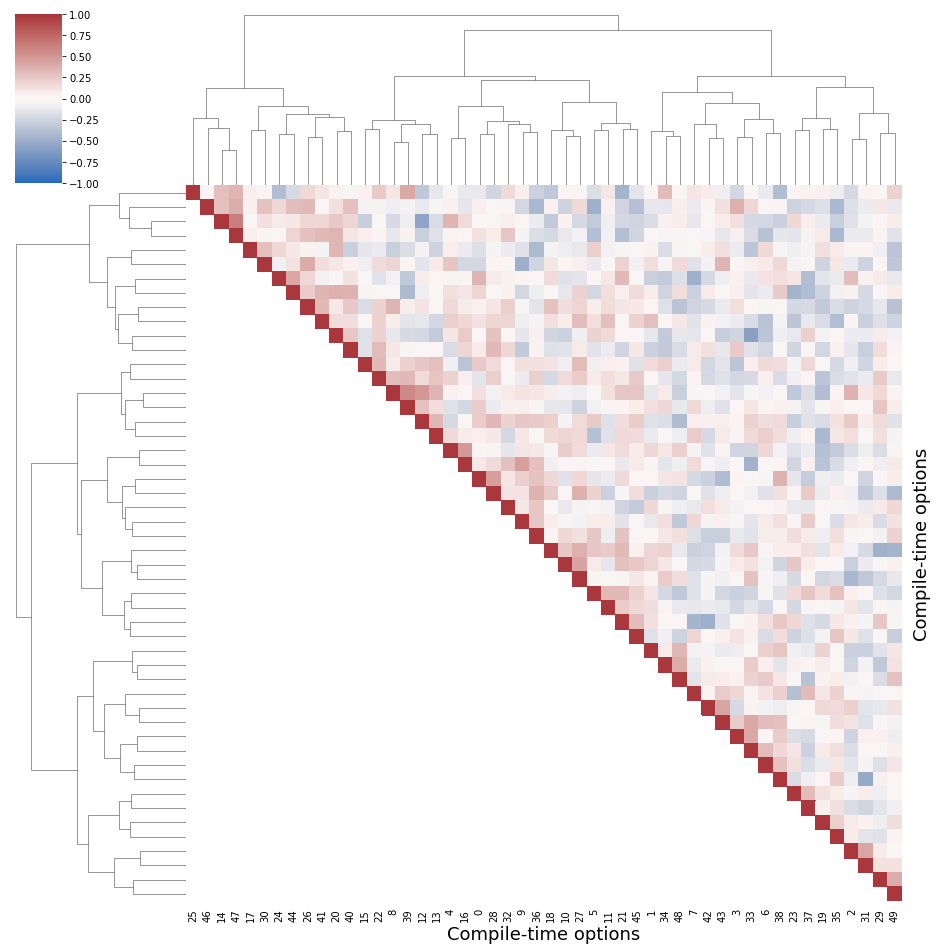

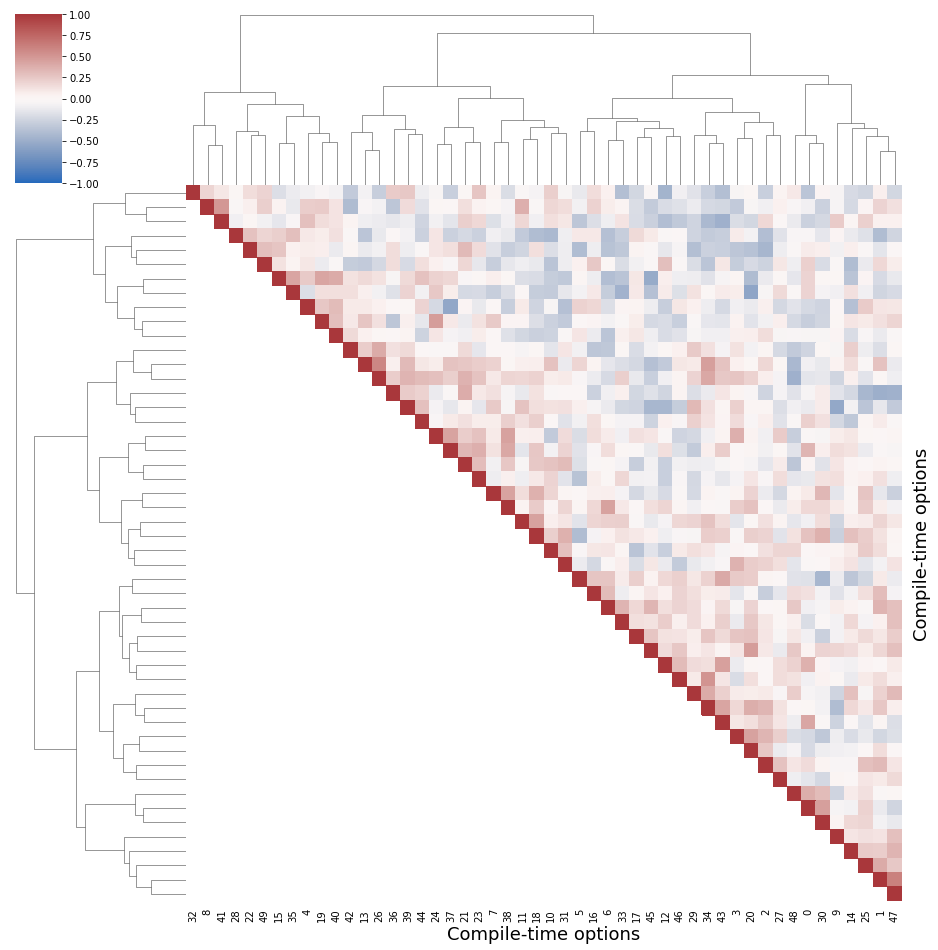

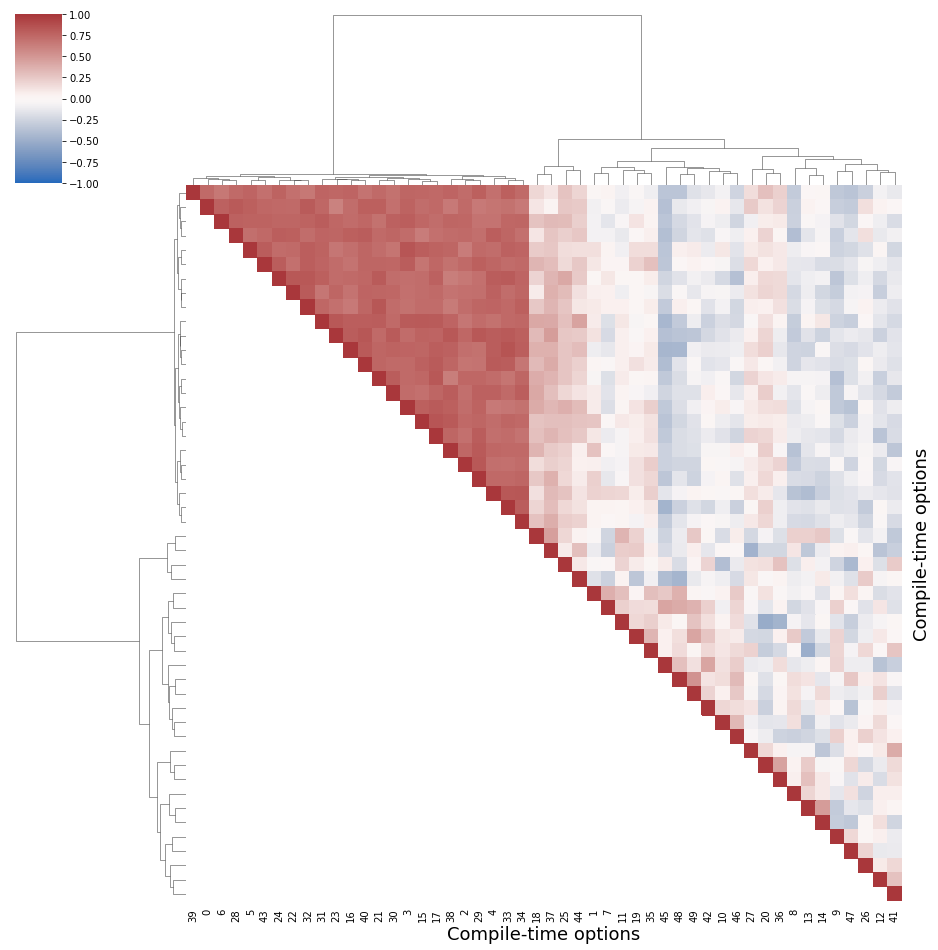

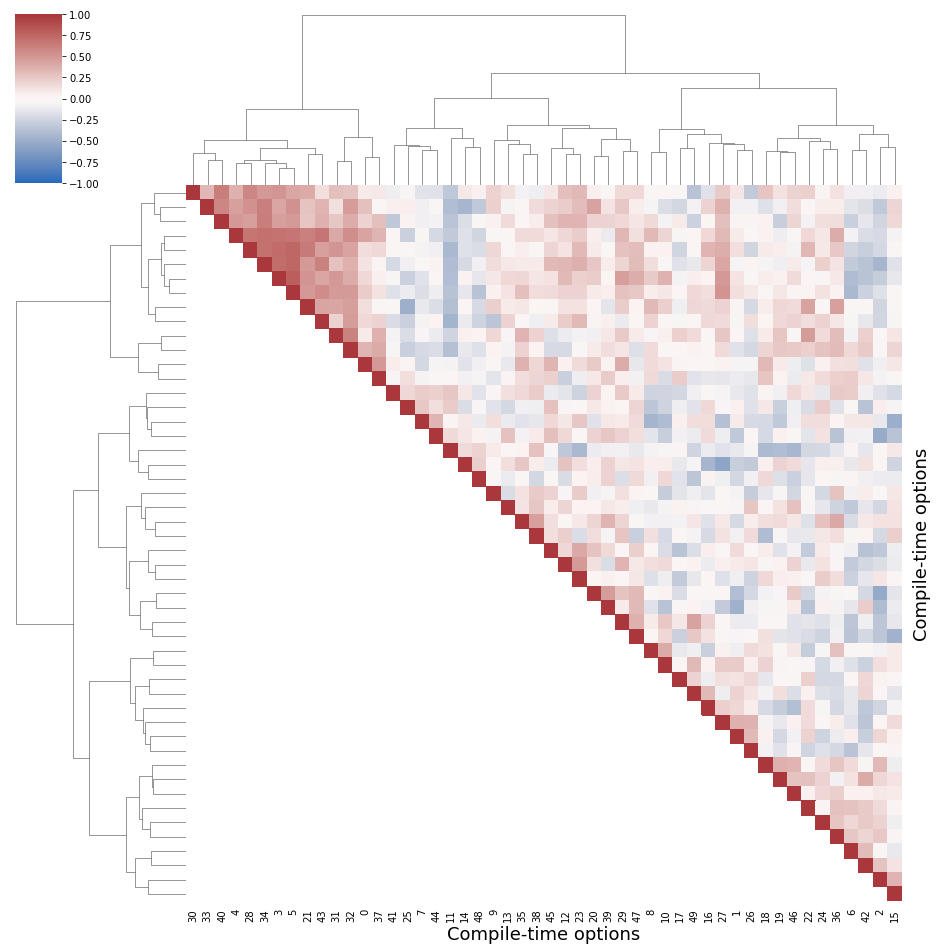

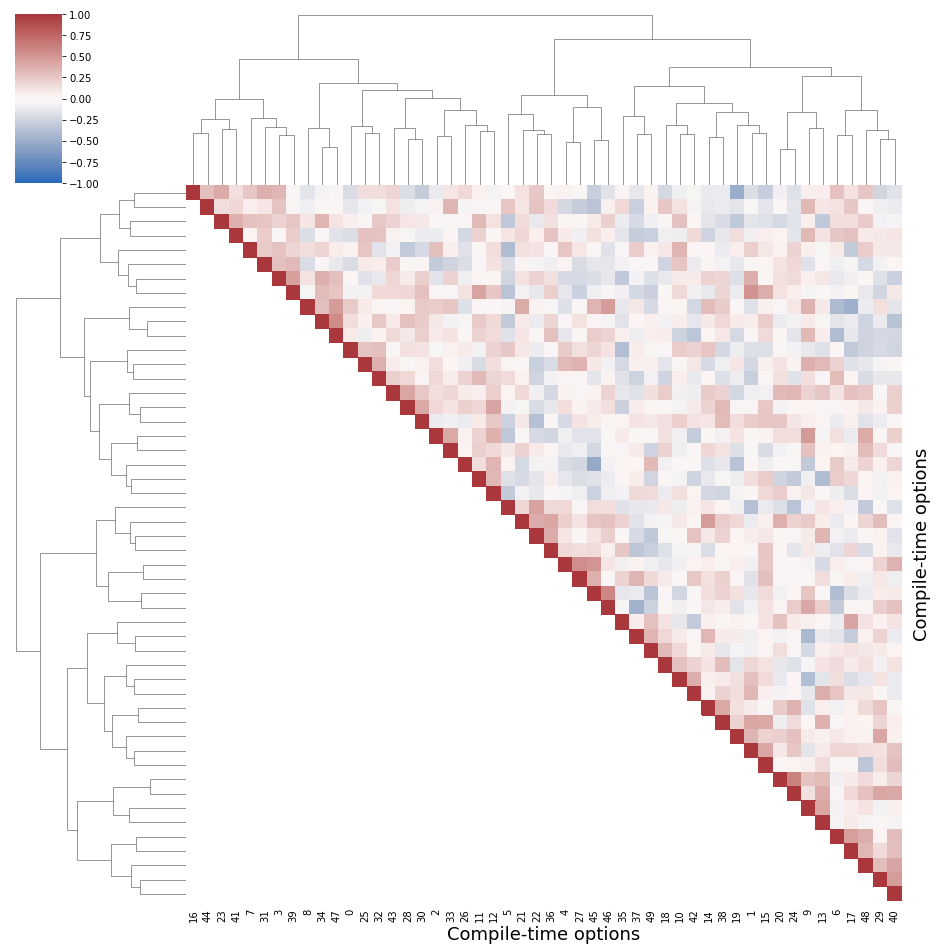

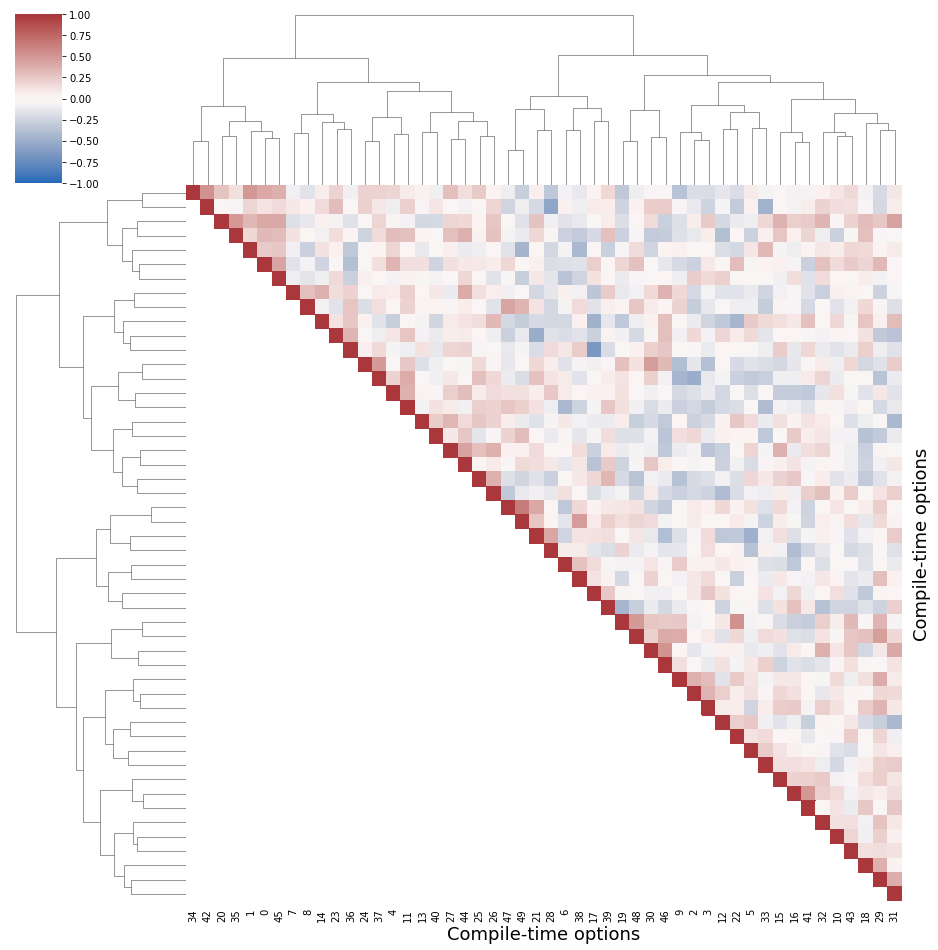

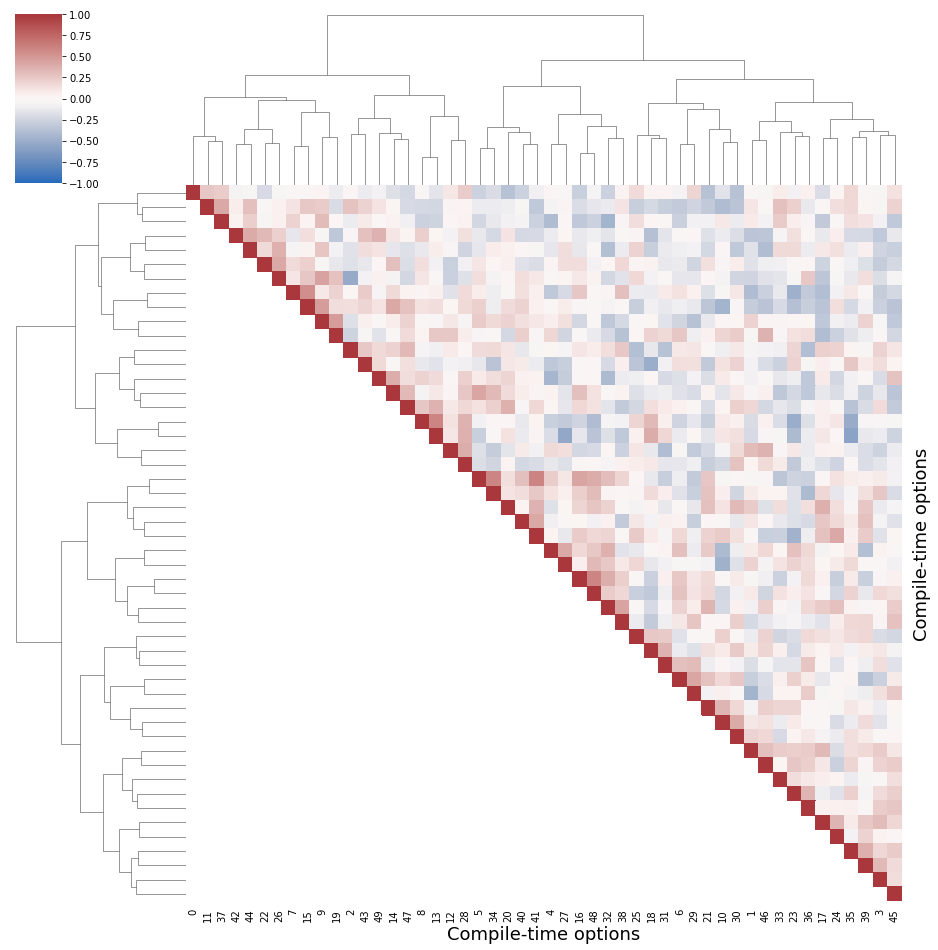

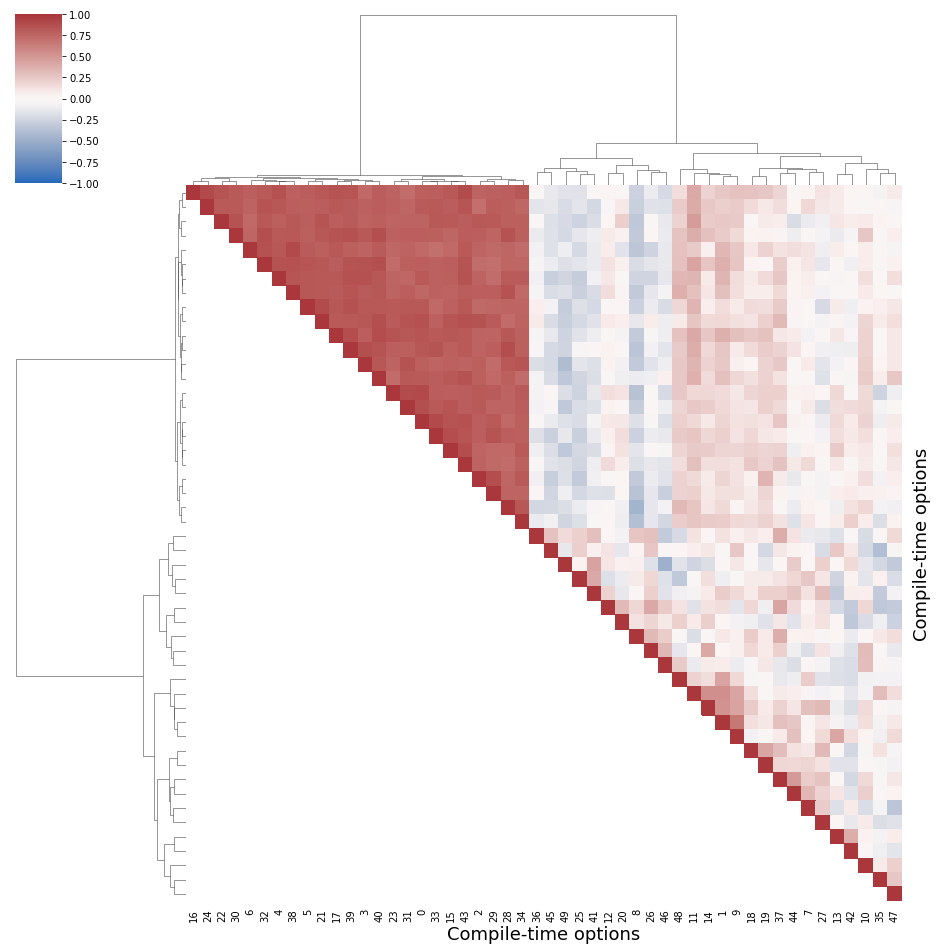

In [26]:
plot_correlationmatrix_dendogram("nodejs", "ops")

In [27]:
#plot_correlationmatrix_dendogram("x264", "size")
#plot_correlationmatrix_dendogram("xz", "size")
#plot_correlationmatrix_dendogram("poppler", "size")

In [28]:
ns = "x264"
dim = "time"
input_index = 7

for input_index in range(8):
    # number of videos
    nb_ctime = len(os.listdir(data_dir+ns))-2

    # matrix of correlations
    corr = [[0 for x in range(nb_ctime)] for y in range(nb_ctime)]

    for i in range(nb_ctime):
        for j in range(nb_ctime):
            if (i == j):
                corr[i][j] = 1
            else:
                corr[i][j] = sc.spearmanr(data[ns, str(i+1), input_index][dim],
                                          data[ns, str(j+1), input_index][dim]).correlation

    print(np.min(corr))

0.9852766941893456
0.9905966420115357
0.9889012774503306
0.9852833332426543
0.9851935755829316
0.9759527056213879
0.986045868973618
0.9880227574996305


In [29]:
ns = "xz"
dim = "time"

for input_index in range(8):
    # number of videos
    nb_ctime = len(os.listdir(data_dir+ns))-2

    # matrix of correlations
    corr = [[0 for x in range(nb_ctime)] for y in range(nb_ctime)]

    for i in range(nb_ctime):
        for j in range(nb_ctime):
            if (i == j):
                corr[i][j] = 1
            else:
                corr[i][j] = sc.spearmanr(data[ns, str(i+1), input_index][dim],
                                          data[ns, str(j+1), input_index][dim]).correlation

    print(np.min(corr))

0.7379310344827587
0.804093897511019
0.7923017069830488
0.5435726244016578
0.780102381482306
0.7743156212261543
0.6259321129473634
0.7155575339416873


In [30]:
ns = "x264"
dim = "time"

for input_index in range(8):
    # number of videos
    nb_ctime = len(os.listdir(data_dir+ns))-2

    # matrix of correlations
    corr = [[0 for x in range(nb_ctime)] for y in range(nb_ctime)]

    for i in range(nb_ctime):
        for j in range(nb_ctime):
            if (i == j):
                corr[i][j] = 1
            else:
                corr[i][j] = sc.spearmanr(data[ns, str(i+1), input_index][dim],
                                          data[ns, str(j+1), input_index][dim]).correlation

    print(np.min(corr))

0.9852766941893456
0.9905966420115357
0.9889012774503306
0.9852833332426543
0.9851935755829316
0.9759527056213879
0.986045868973618
0.9880227574996305


In [31]:
ns = "nodejs"
dim = "ops"
input_index = 9

# number of videos
nb_ctime = len(os.listdir(data_dir+ns))-2

# matrix of correlations
corr = [[0 for x in range(nb_ctime)] for y in range(nb_ctime)]

for i in range(nb_ctime):
    for j in range(nb_ctime):
        if (i == j):
            corr[i][j] = 1
        else:
            corr[i][j] = sc.spearmanr(data[ns, str(i+1), input_index][dim],
                                      data[ns, str(j+1), input_index][dim]).correlation

In [32]:
np.mean(corr[16][24])

0.9038932146829811

In [33]:
np.mean(corr[40][23])

0.7294771968854282

In [34]:
np.mean(corr[27][13])

0.011345939933259176

In [35]:
np.mean(corr[29][8])

-0.3539488320355951

### Binary trees

In [31]:
perfs = dict()

perfs["nodejs"] = ["ops"]
perfs["poppler"] = ["time", "size"]
perfs["x264"] = ["kbs", "fps", "size", "time", "frames"]
perfs["xz"] = ["time", "size"]

def aggregate_data(ns, input_index, dim):
    
    nb_ctime = len(os.listdir(data_dir+ns))-2
    
    ctime_data = pd.read_csv(data_dir+ns+"/ctime_options.csv")
    
    # we delete the other perfs to avoid ocnsidering them as predicting variables
    to_delete_perfs = list(perfs[ns])
    to_delete_perfs.remove(dim)
    to_delete_perfs.append('configurationID')
    
    aggreg_vals = []

    for index_comp in range(nb_ctime):
        
        val = ctime_data.iloc[index_comp][1:]
        
        df_runtime = data[ns, str(index_comp+1), input_index]
        df_runtime = df_runtime.drop(to_delete_perfs, axis = 1)
        
        df_runtime_modif = pd.get_dummies(df_runtime.drop([dim], axis=1))
        df_runtime_modif[dim] = df_runtime[dim]
        
        for rt_config_id in range(df_runtime.shape[0]):
            aggreg_vals.append(list(tuple(val) + tuple(df_runtime_modif.loc[rt_config_id])))
        
    res_df = pd.DataFrame(aggreg_vals)
    res_df.columns = list(tuple(ctime_data.columns[1:]) + tuple(df_runtime_modif.columns))
    
    return res_df

def draw_tree(ns, input_index, dim, max_depth):
    
    res_df = aggregate_data(ns, input_index, dim)

    y = res_df[dim]
    X = res_df.drop([dim], axis=1)

    dt = DecisionTreeRegressor(max_depth = max_depth)
    dt.fit(X,y)

    plt.figure(figsize=(20,20))
    plot_tree(dt, feature_names=res_df.columns, filled=True)
    plt.savefig("../results/"+ns+"/tree_input_"+str(input_index+1)+"_"+dim+".png")
    plt.show()

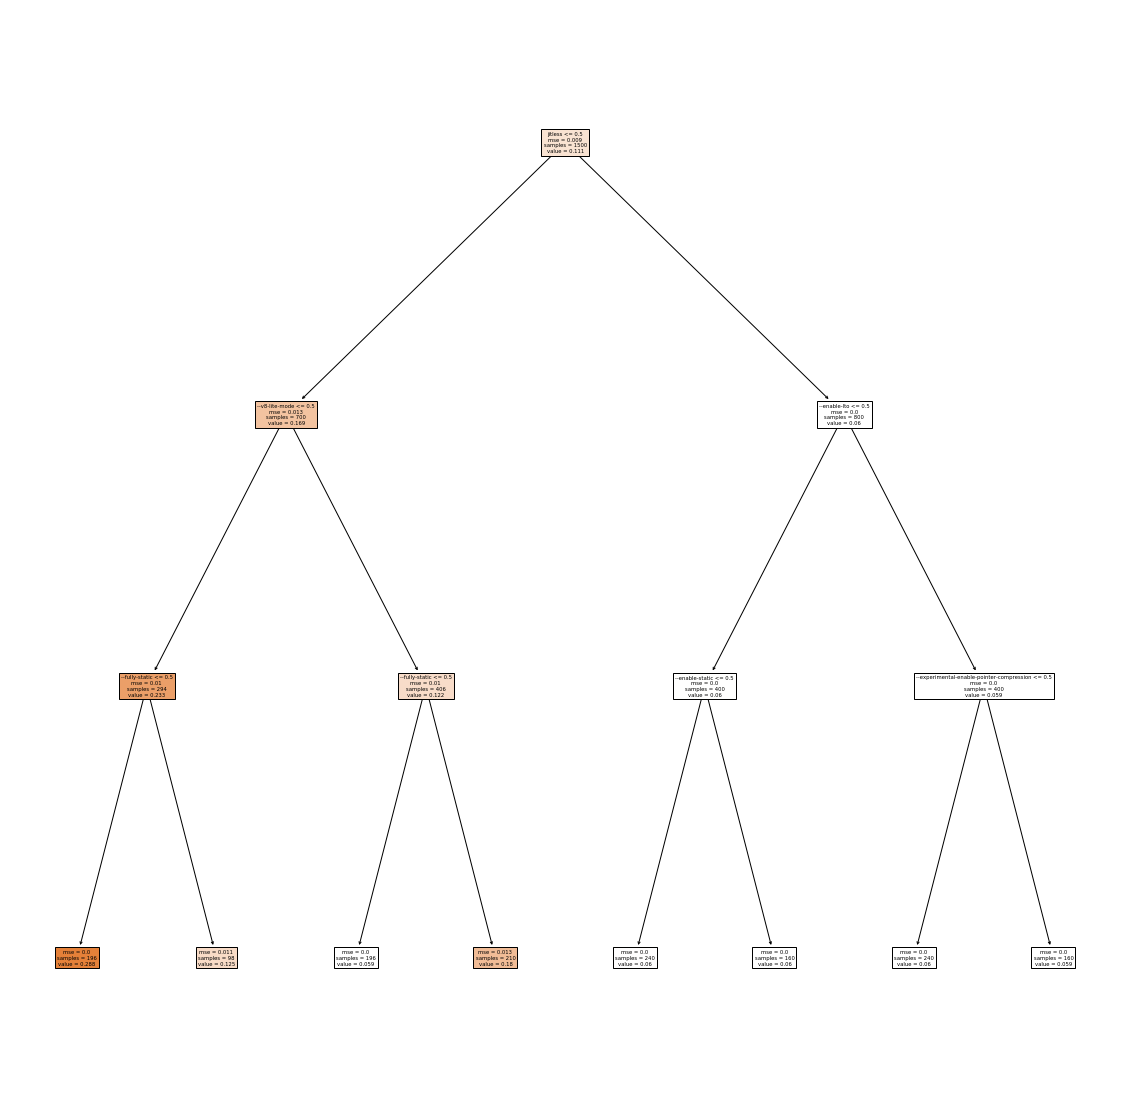

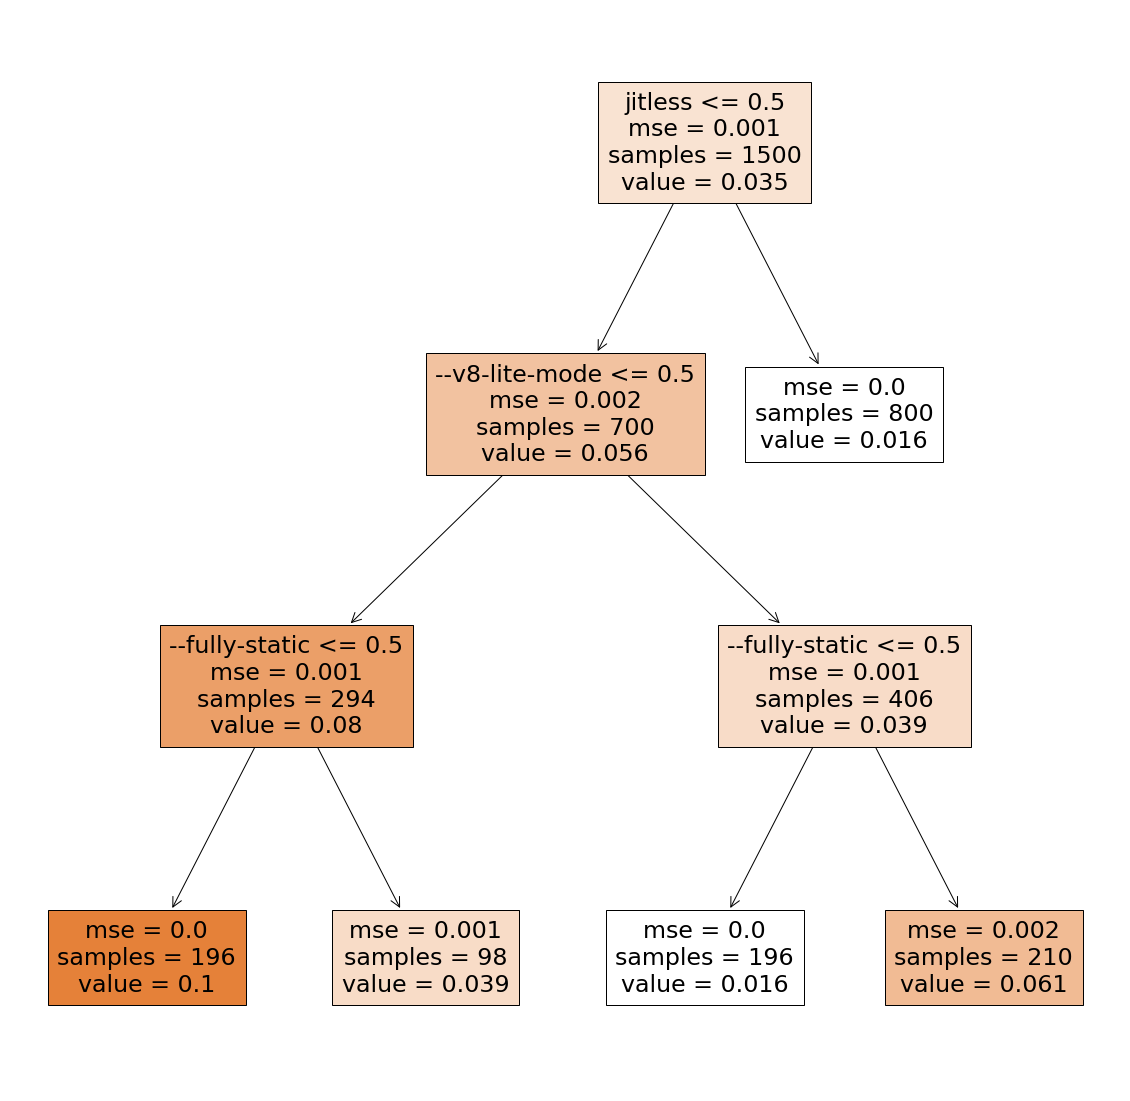

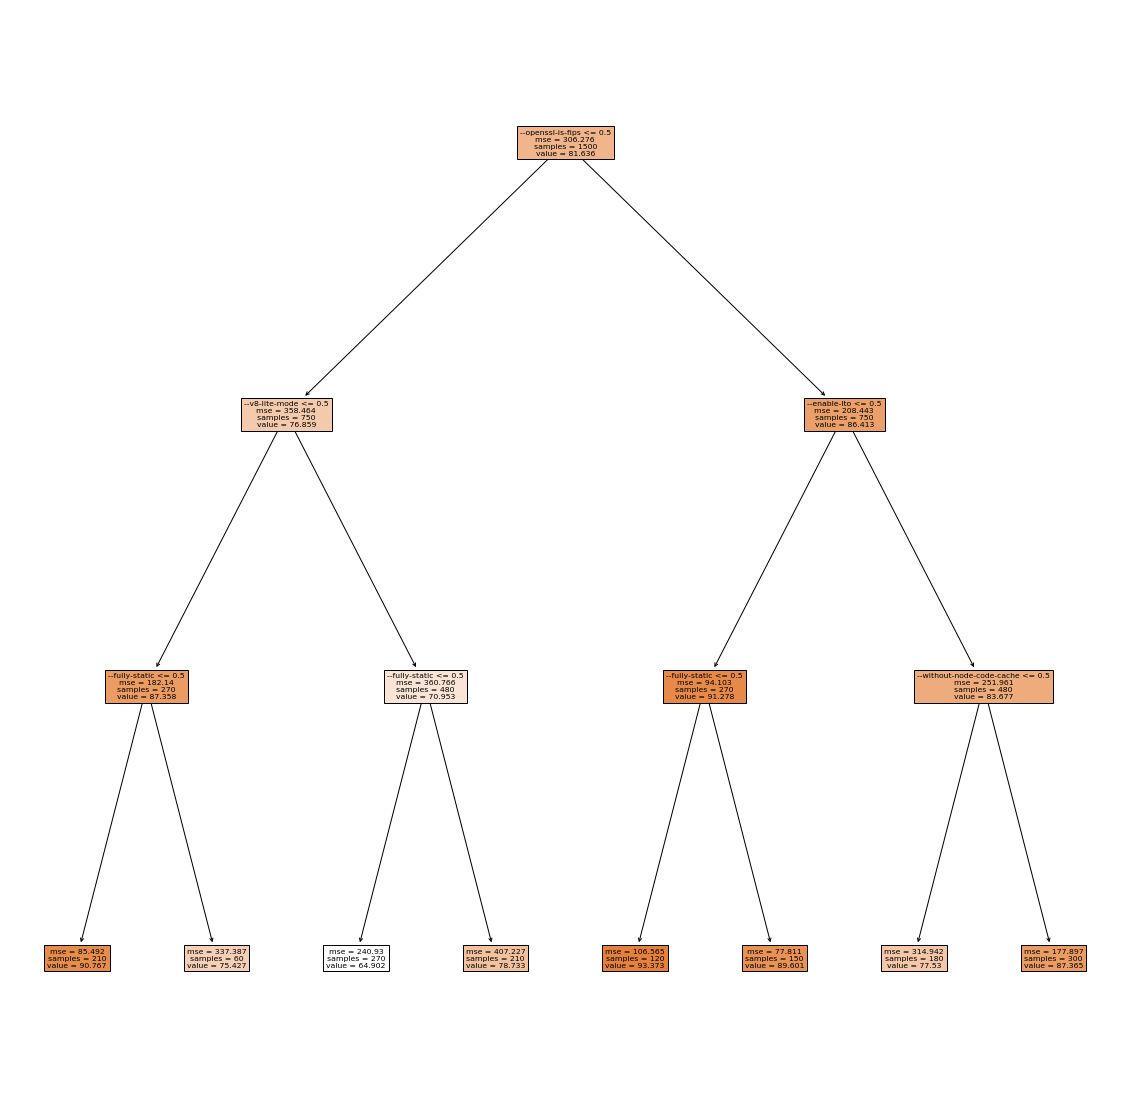

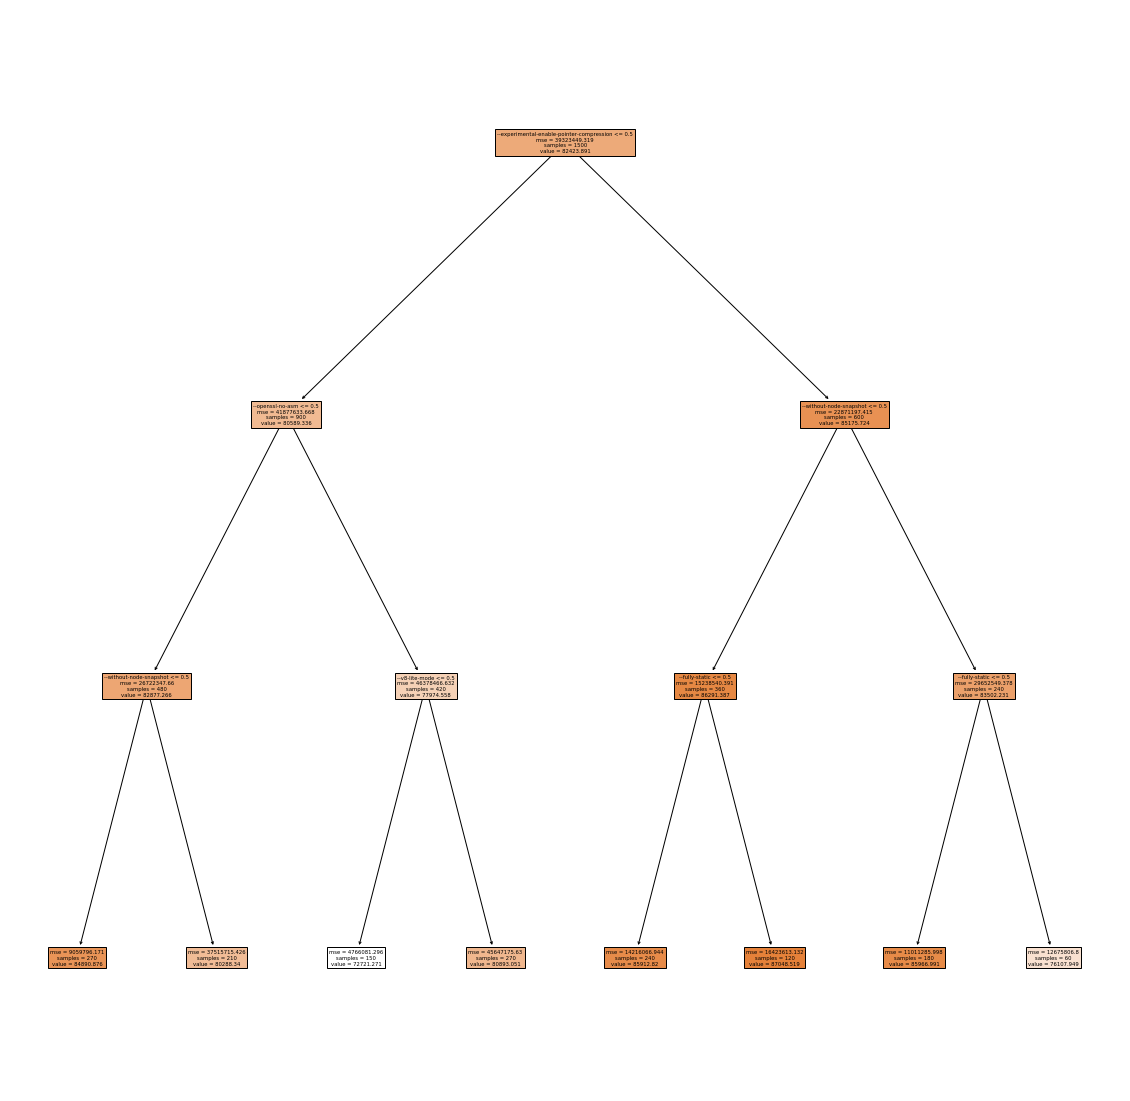

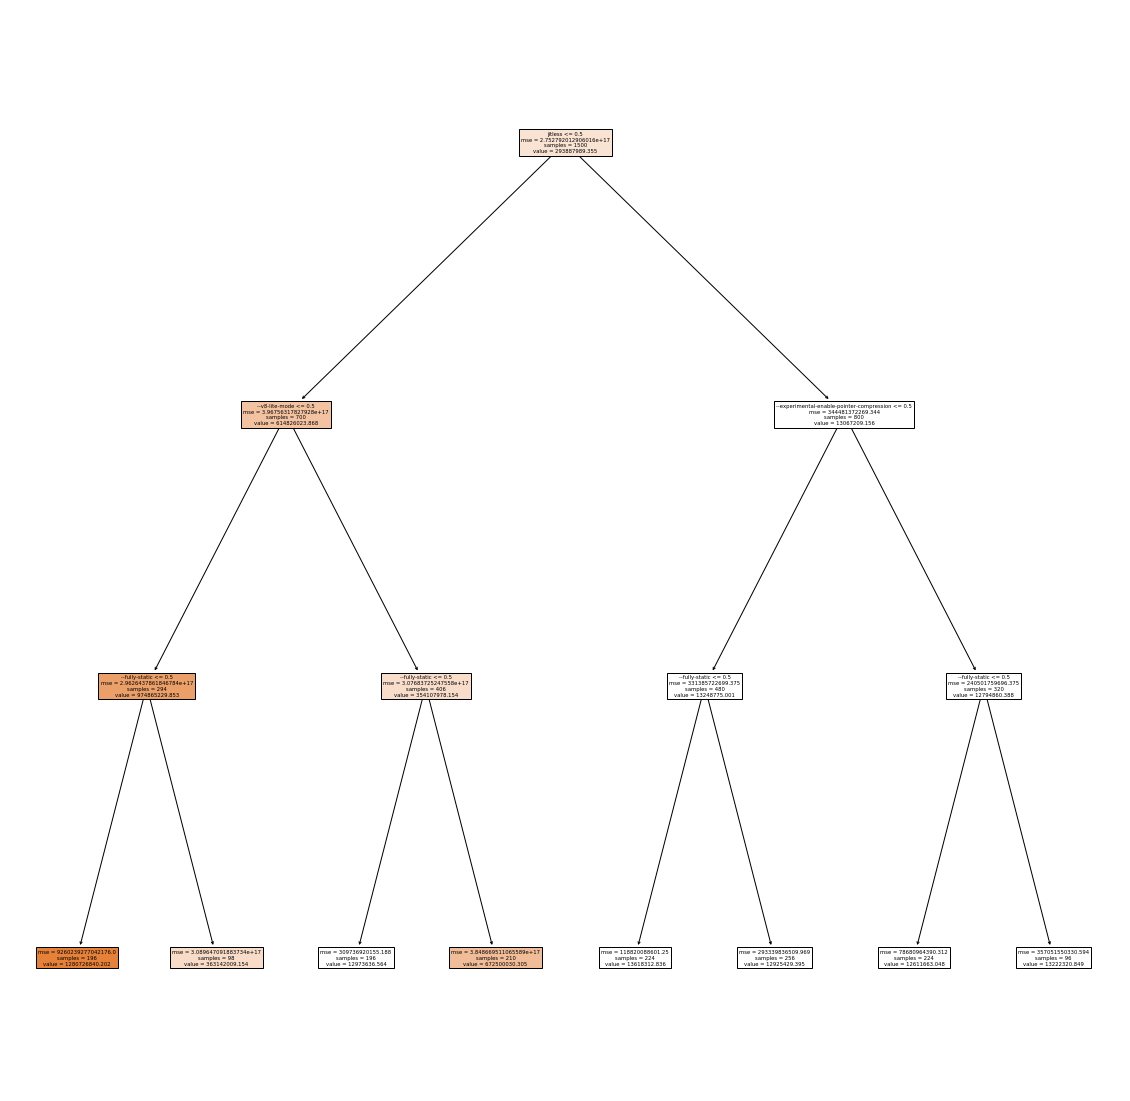

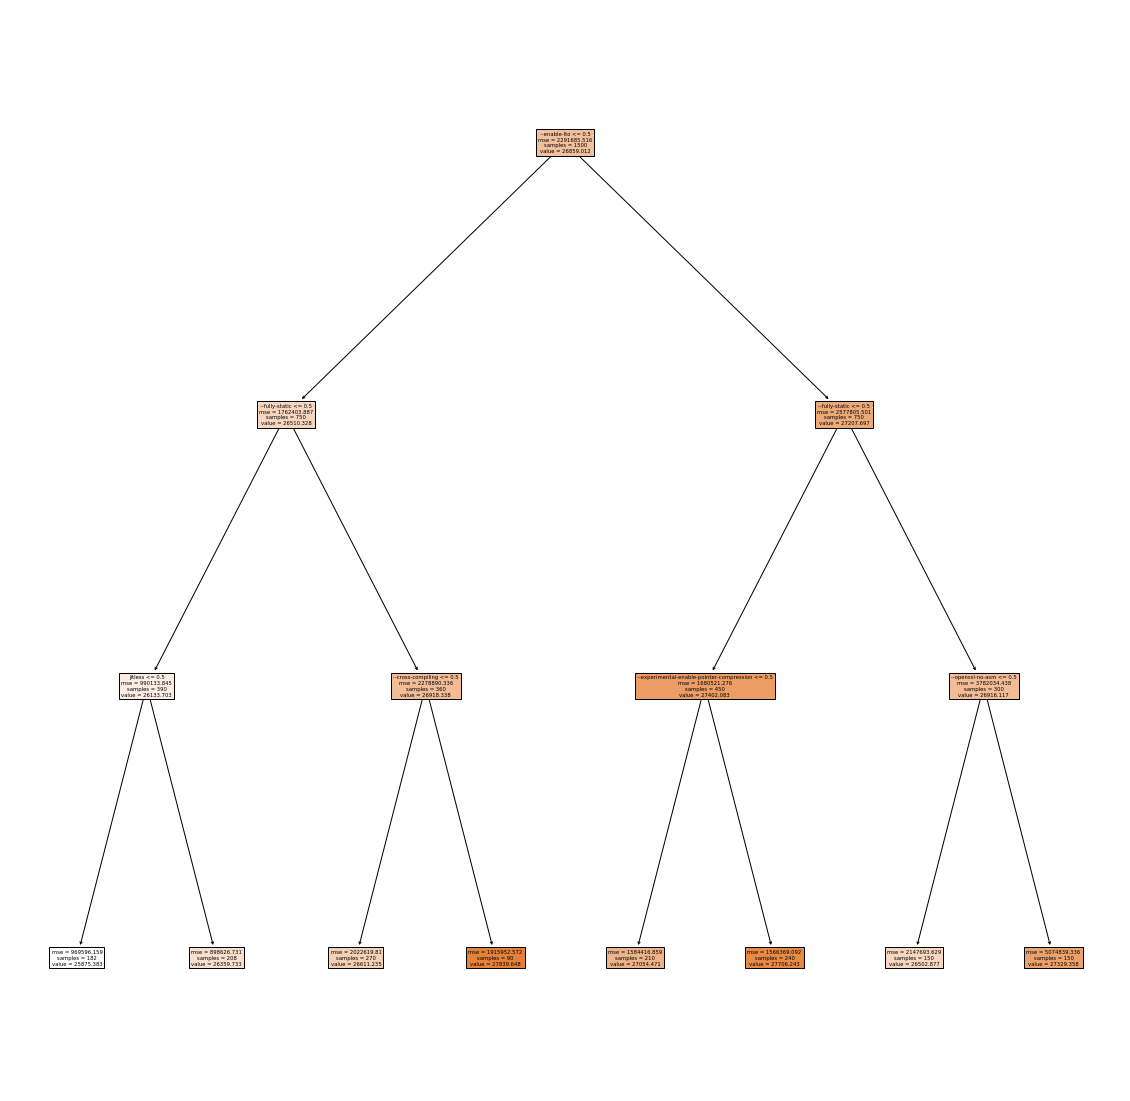

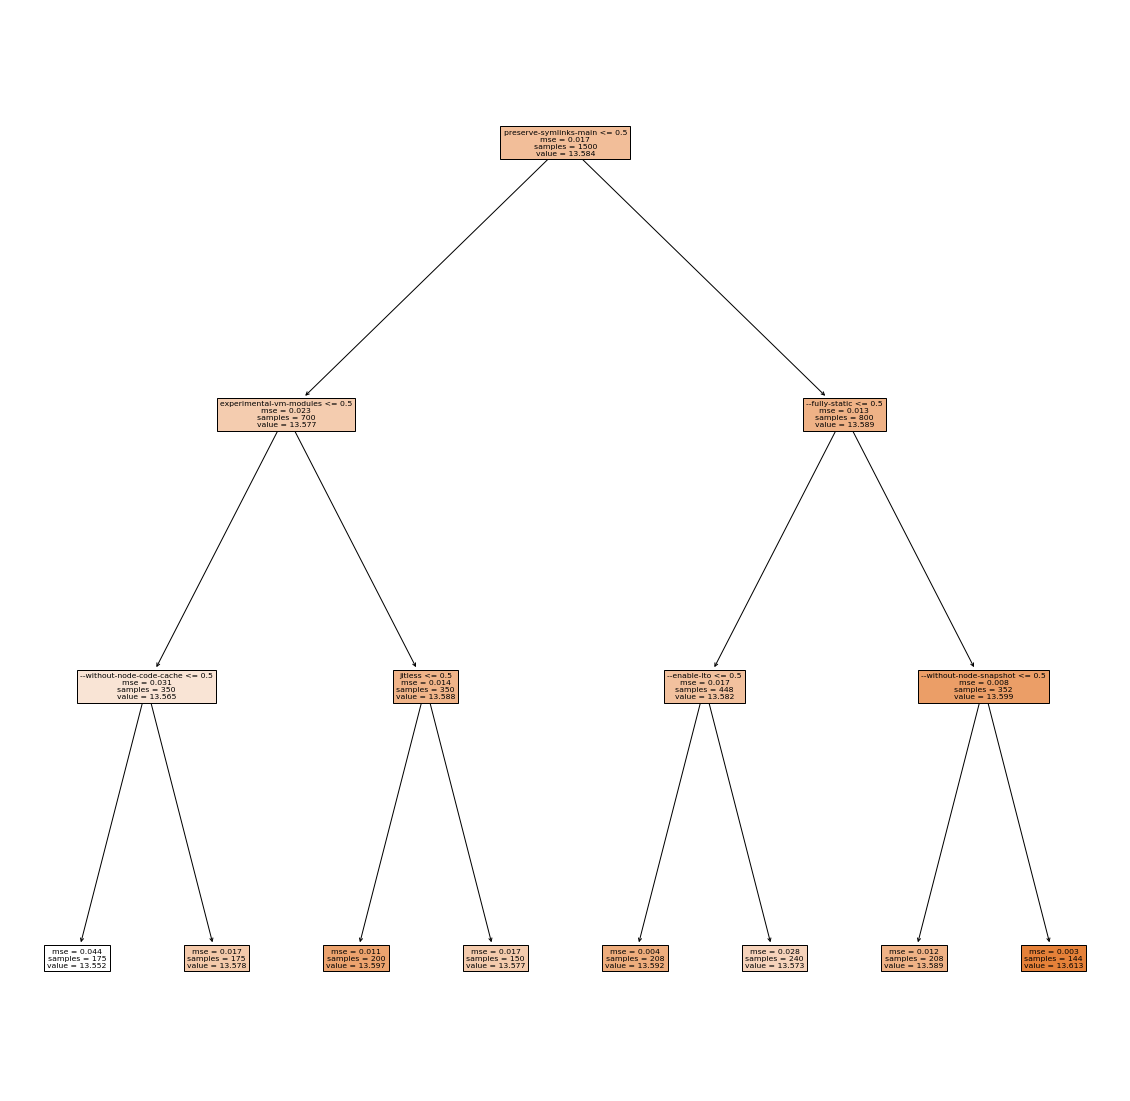

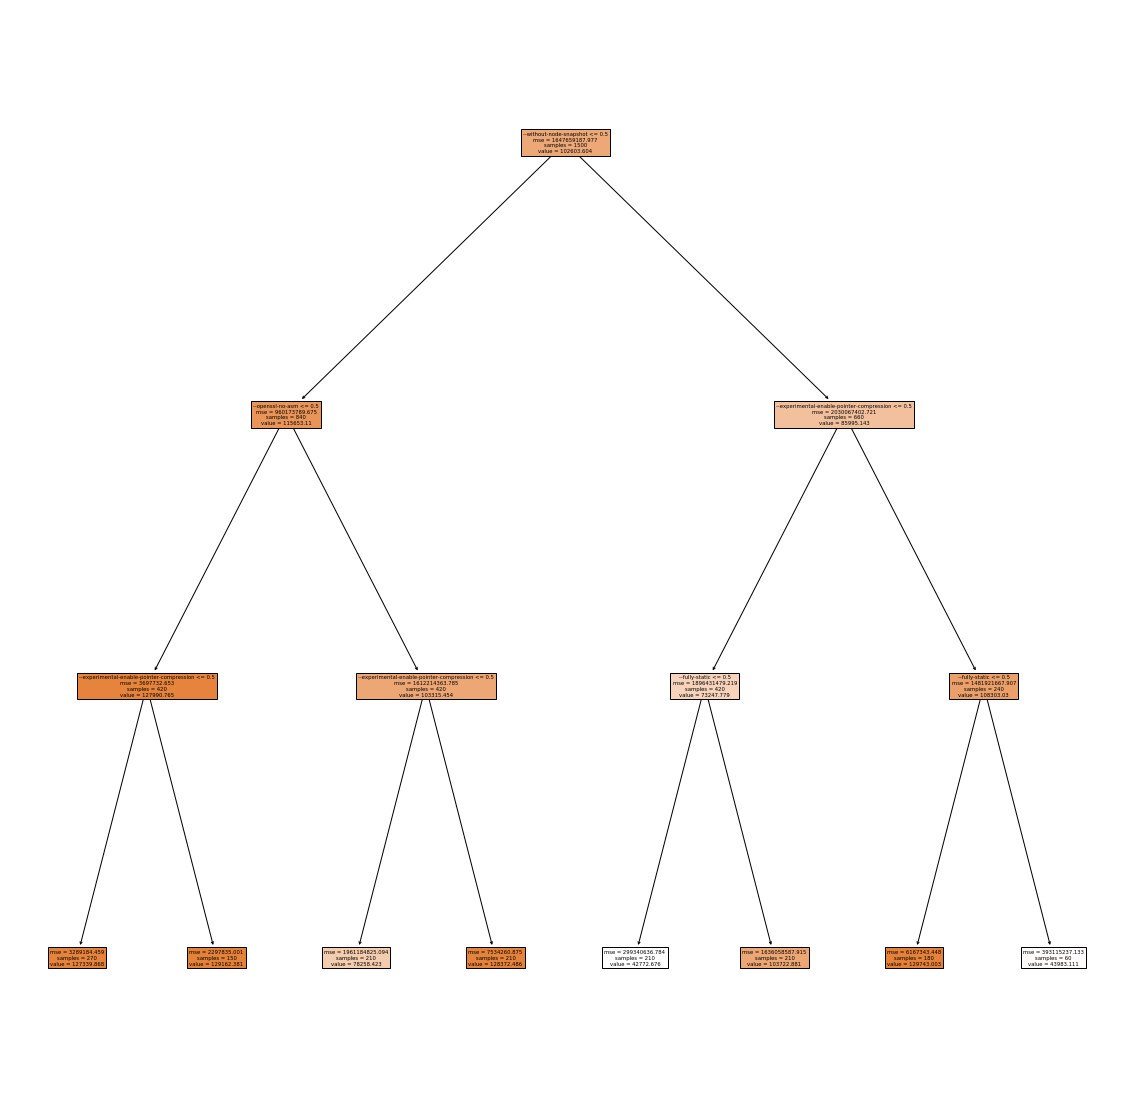

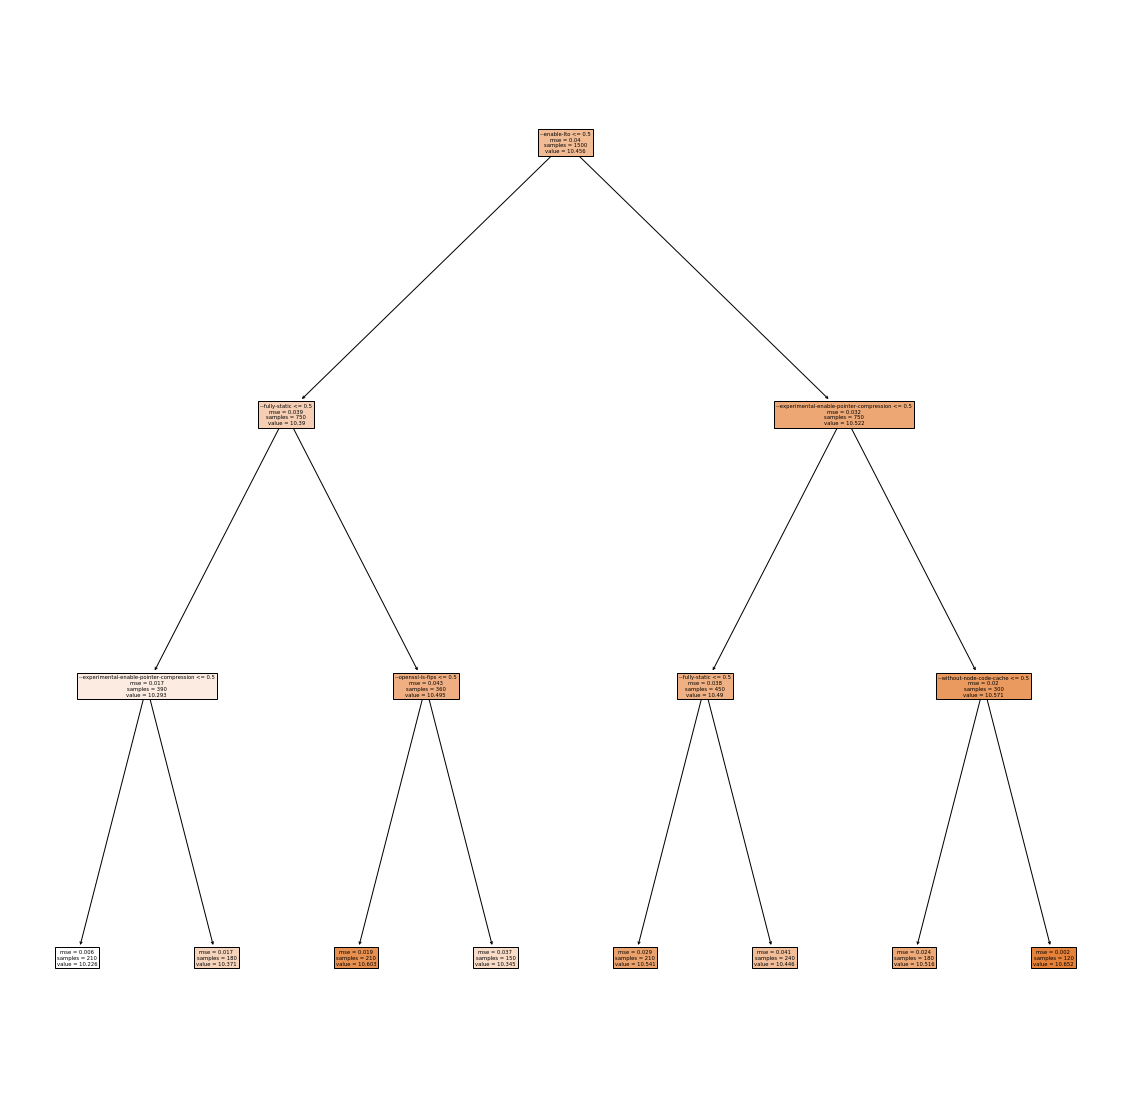

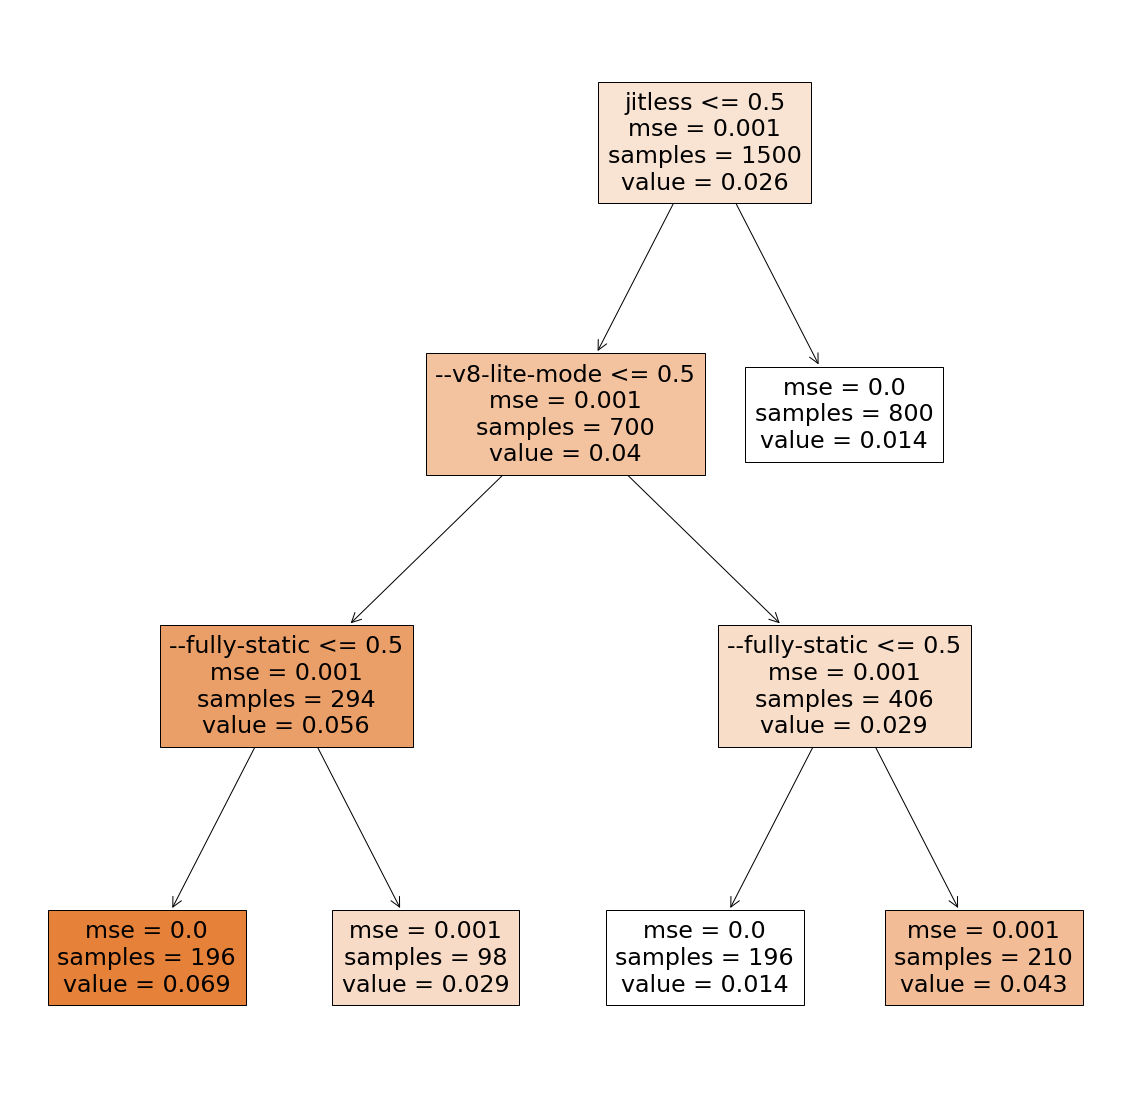

In [37]:
for i in range(len(inputs_name["nodejs"])):
    draw_tree("nodejs", i, "ops", 3)

### Feature importances

In [101]:
def show_imp(ns, input_index, dim, col_names=None, color=None):
    
    res_df = aggregate_data(ns, input_index, dim)

    y = res_df[dim]
    X = res_df.drop([dim], axis=1)

    rf = RandomForestRegressor()
    rf.fit(X,y)
    
    res_imp = pd.Series(rf.feature_importances_, res_df.columns[:-1])
    res_imp
    
    plt.figure(figsize = (20,10))
    plt.grid()
    plt.ylabel("Random Forest importance (%)", size = 25)
    plt.yticks(size=25)
    if color:
        plt.bar(range(len(res_imp.values)), 100*res_imp, color= color)
    else:
        plt.bar(range(len(res_imp.values)), 100*res_imp)
    if col_names:
        plt.xticks(range(len(res_imp.values)), col_names, rotation=45, size =25)
    else:
        plt.xticks(range(len(res_imp.values)), res_imp.index, rotation=45, size =25)
    plt.savefig("../results/"+ns+"/rf_input_"+str(input_index+1)+"_"+dim+".png")
    plt.show()

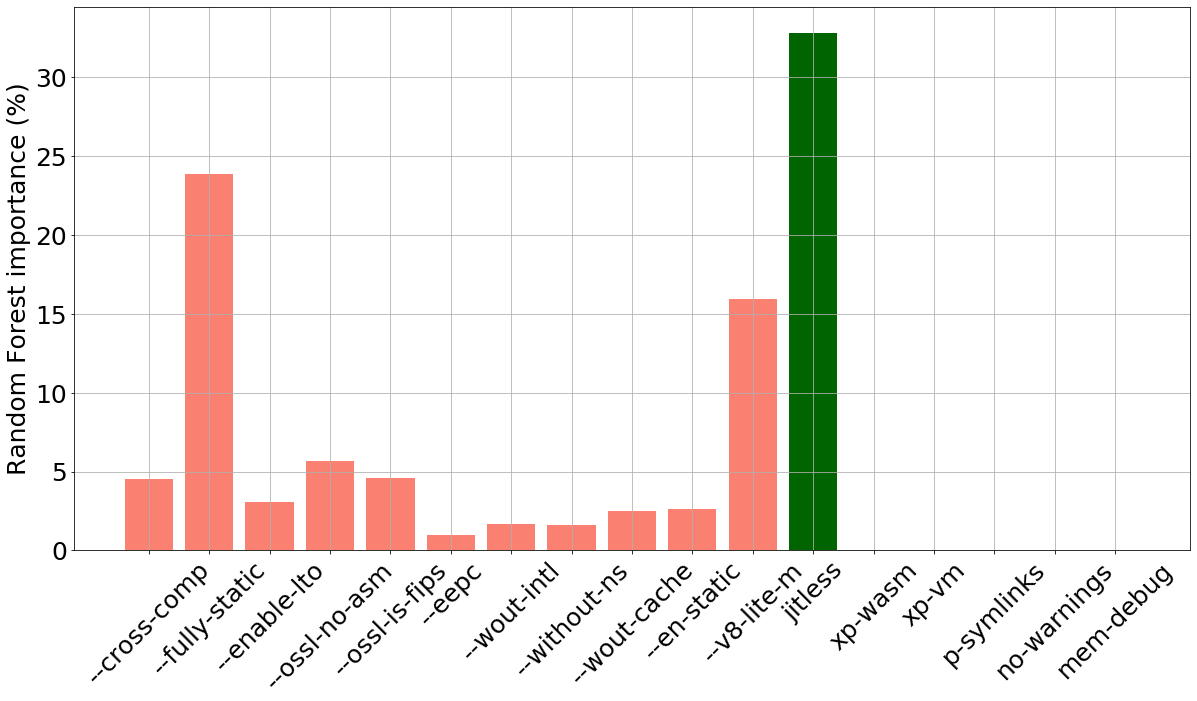

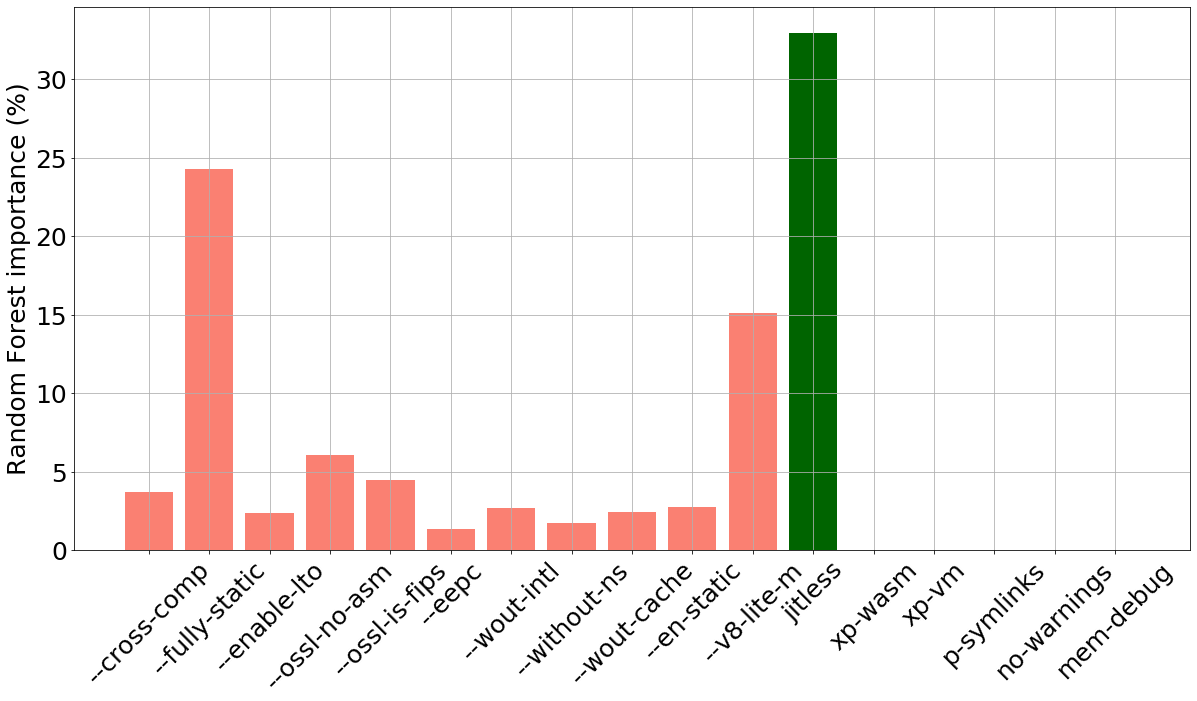

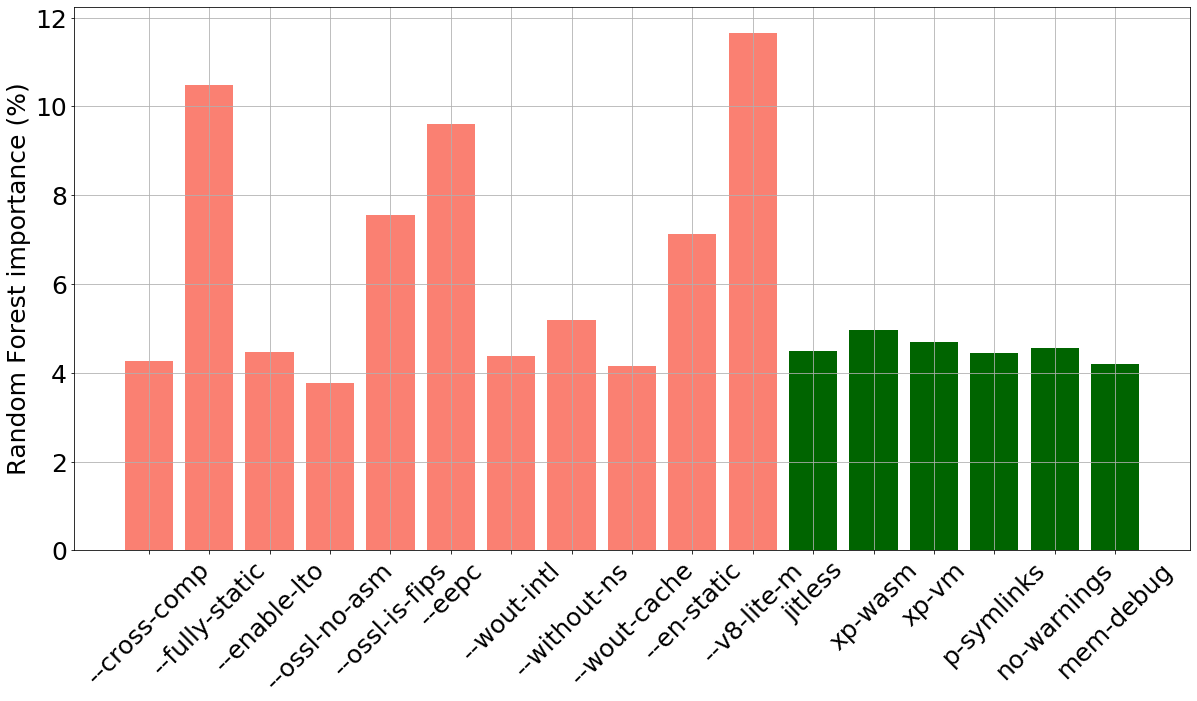

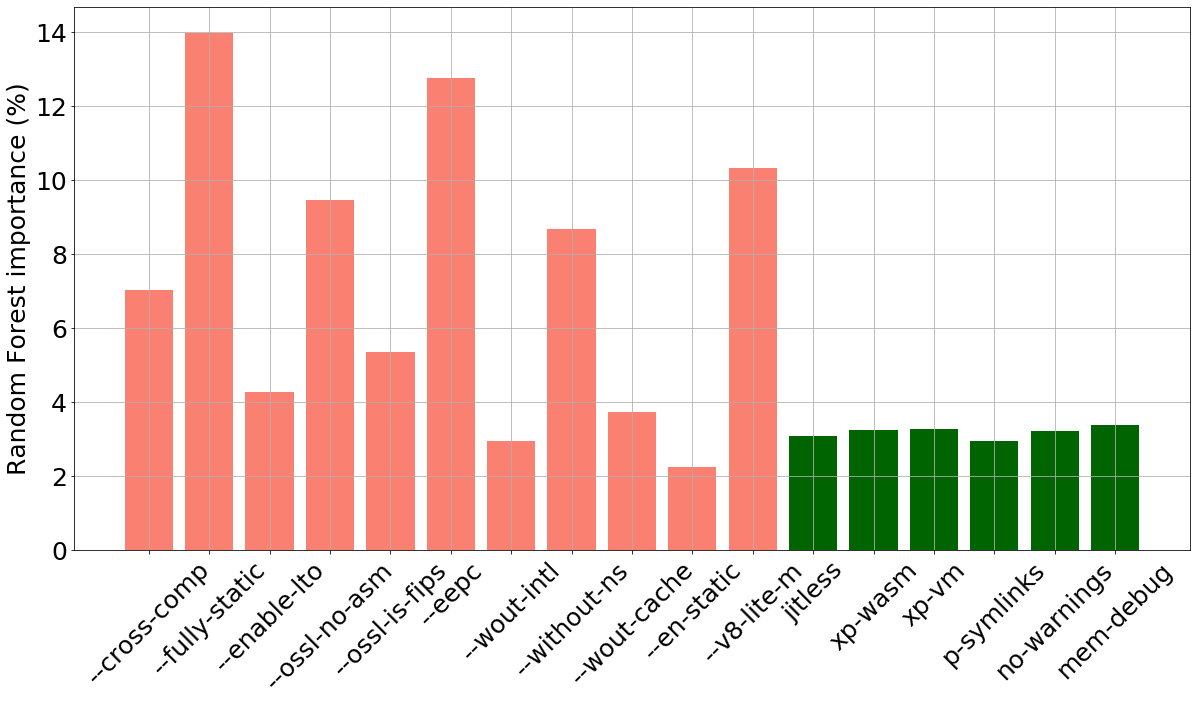

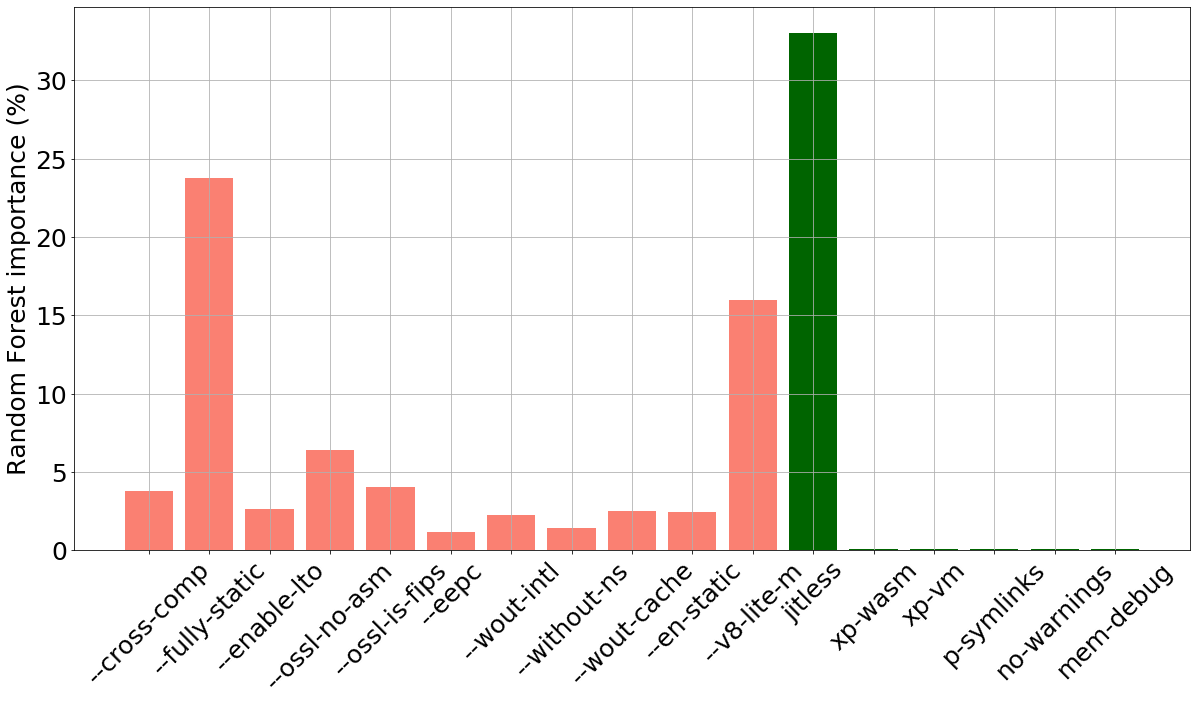

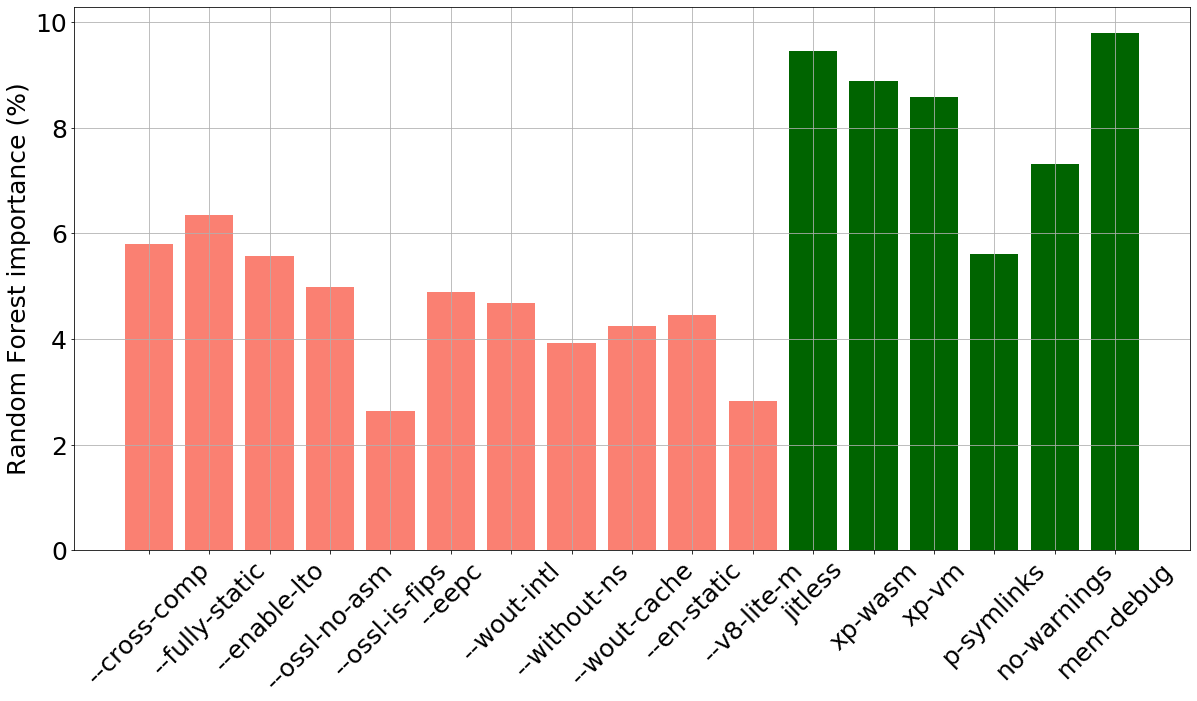

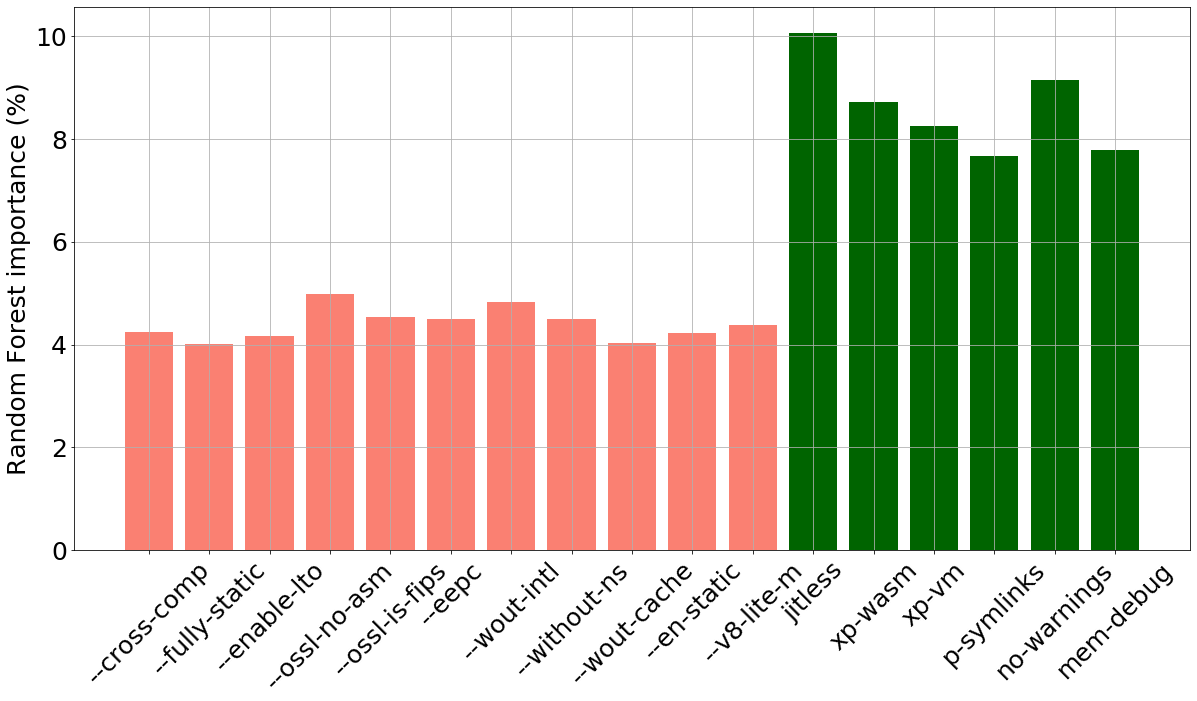

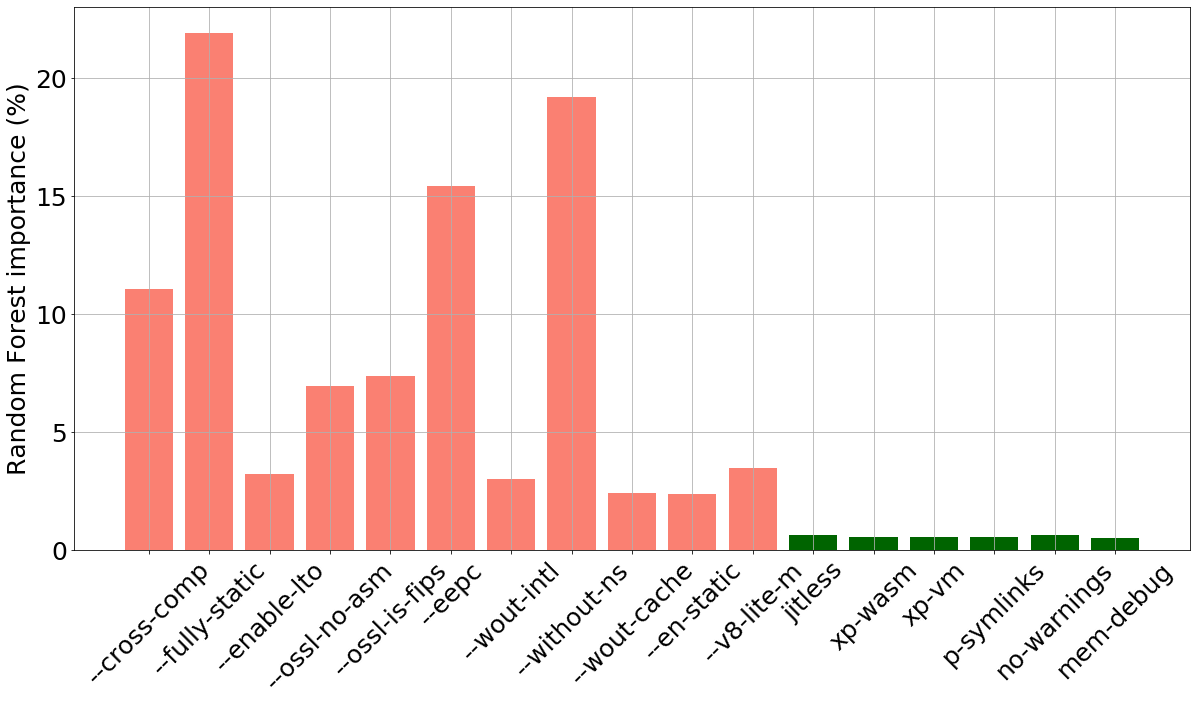

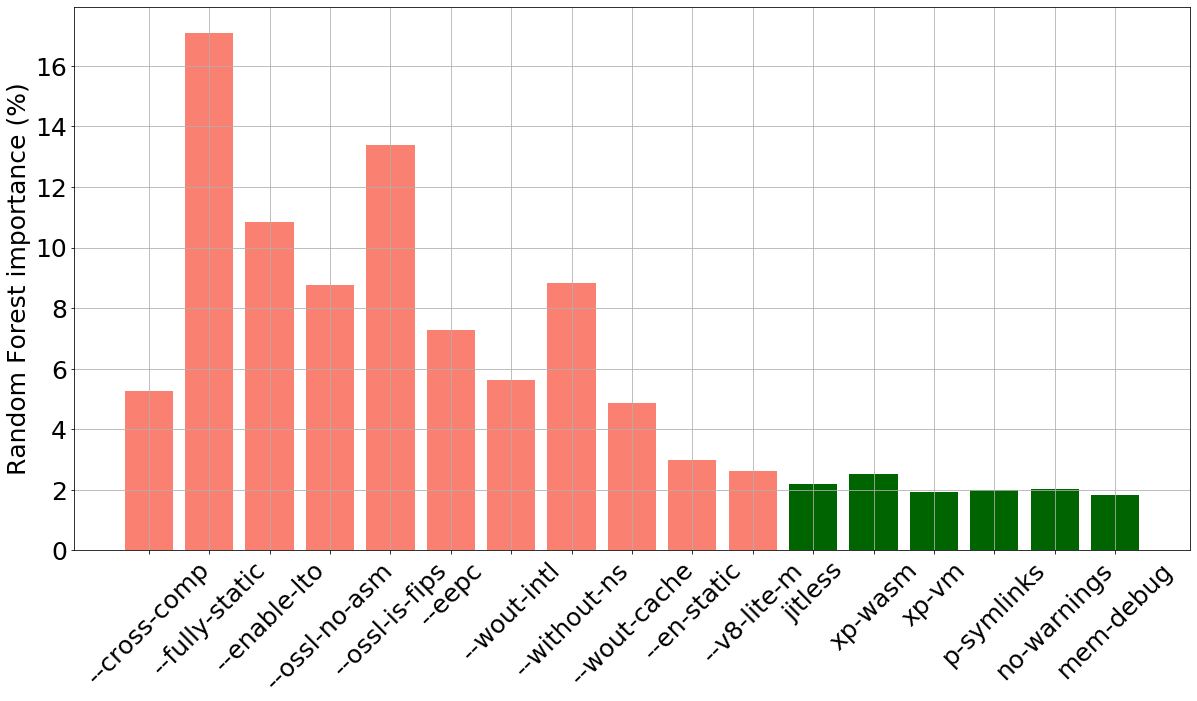

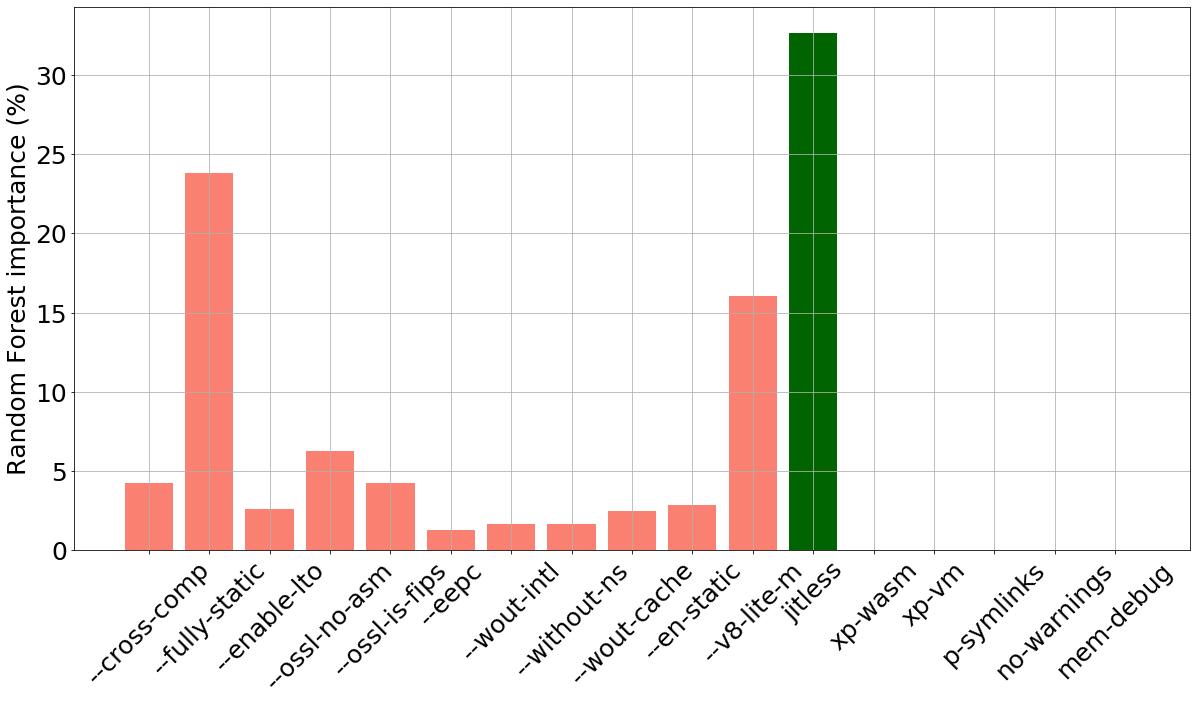

In [98]:
col_node = ['--cross-comp', '--fully-static', '--enable-lto',
       '--ossl-no-asm', '--ossl-is-fips',
       '--eepc', '--wout-intl',
       '--without-ns', '--wout-cache',
       '--en-static', '--v8-lite-m', 'jitless',
       'xp-wasm', 'xp-vm',
       'p-symlinks', 'no-warnings', 'mem-debug']

color = ["salmon"]*11+["darkgreen"]*6

for i in range(len(inputs_name["nodejs"])):
    show_imp("nodejs", i, "ops", col_node, color)

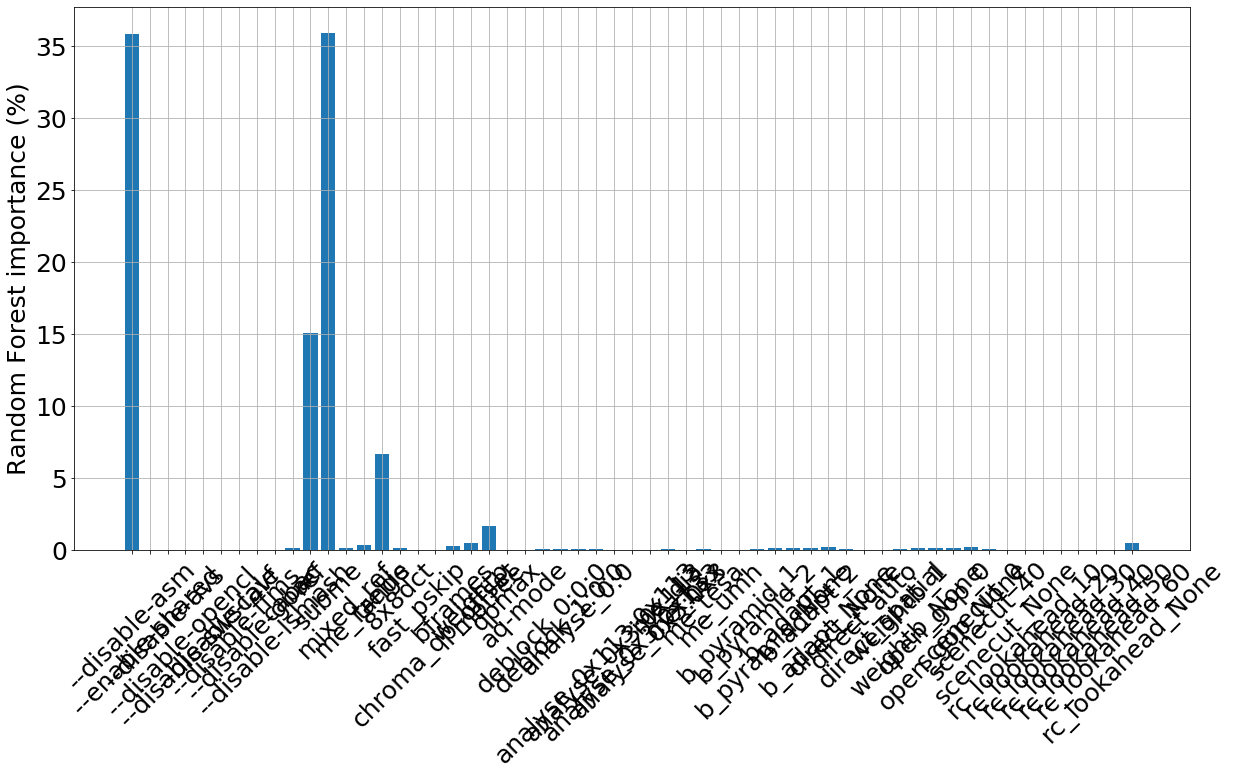

In [103]:
show_imp("x264", 1, "fps")

## With the feature interactions

In [64]:
def show_imp_interact(ns, input_index, dim):
    
    res_df = aggregate_data(ns, input_index, dim)

    y = res_df[dim]
    X = res_df.drop([dim], axis=1)
    
    poly = PolynomialFeatures(degree = 2, interaction_only = False, include_bias = True)
    X_interact = pd.DataFrame(np.array(poly.fit_transform(X), int))

    rf = RandomForestRegressor()
    rf.fit(X_interact,y)
    
    names_interactions = [str(1)]

    xs = X.columns

    for f in xs:
        names_interactions.append(f)

    for i in range(len(xs)):
        first_f = xs[i]
        for j in range(len(xs)):
            sec_f = xs[j]
            if i ==j:
                names_interactions.append(first_f+"^2")
            else:
                if i <j:
                    names_interactions.append(first_f+" "+sec_f)
    
    names = poly.get_feature_names()
    
    res_imp = pd.Series(rf.feature_importances_, names_interactions)
    res_imp
    
    plt.figure(figsize = (20,10))
    plt.grid()
    plt.ylabel("Random Forest importance (%)", size = 25)
    plt.yticks(size=25)
    plt.bar(range(len(res_imp.values)), 100*res_imp)
    plt.xticks(range(len(res_imp.values)), res_imp.index, rotation=45, size =10)
    plt.savefig("../results/"+ns+"/rf_imp_interact_input_"+str(input_index+1)+"_"+dim+".png")
    plt.show()
    
    return res_imp

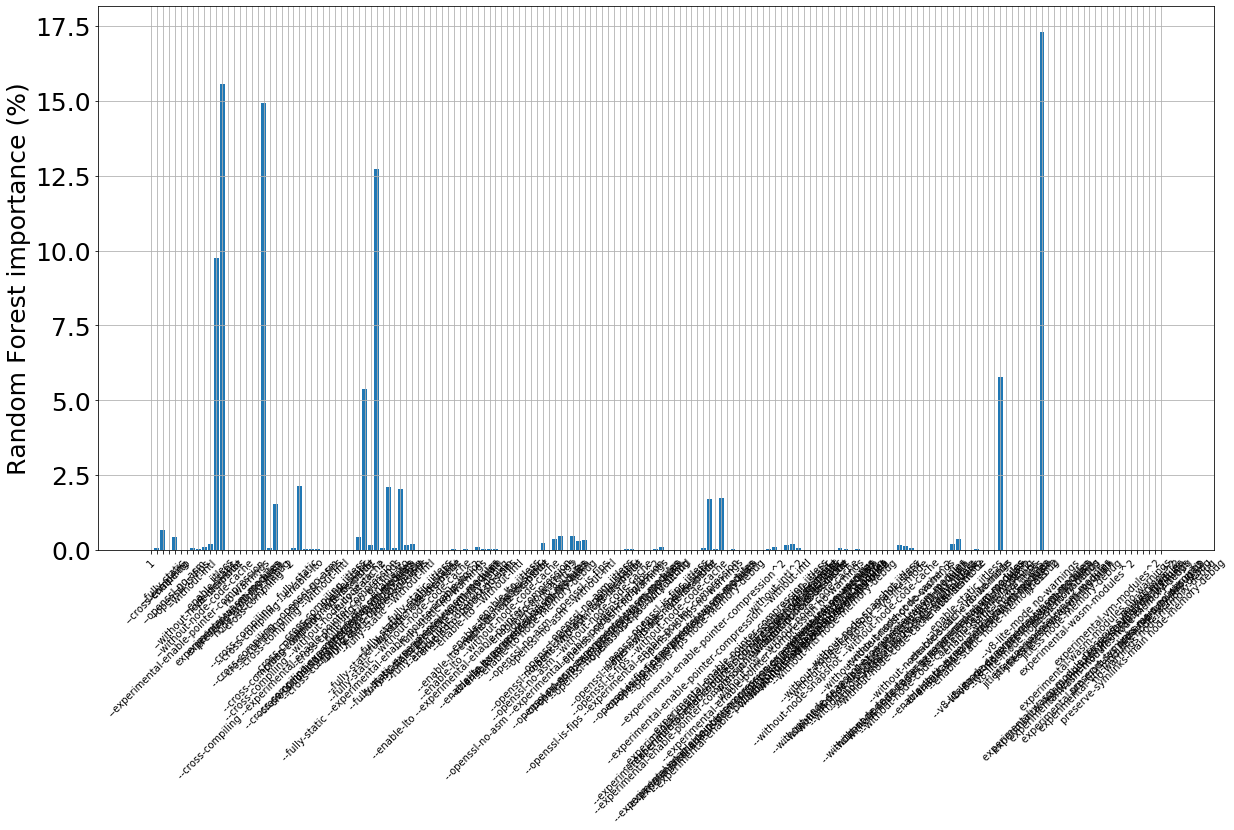

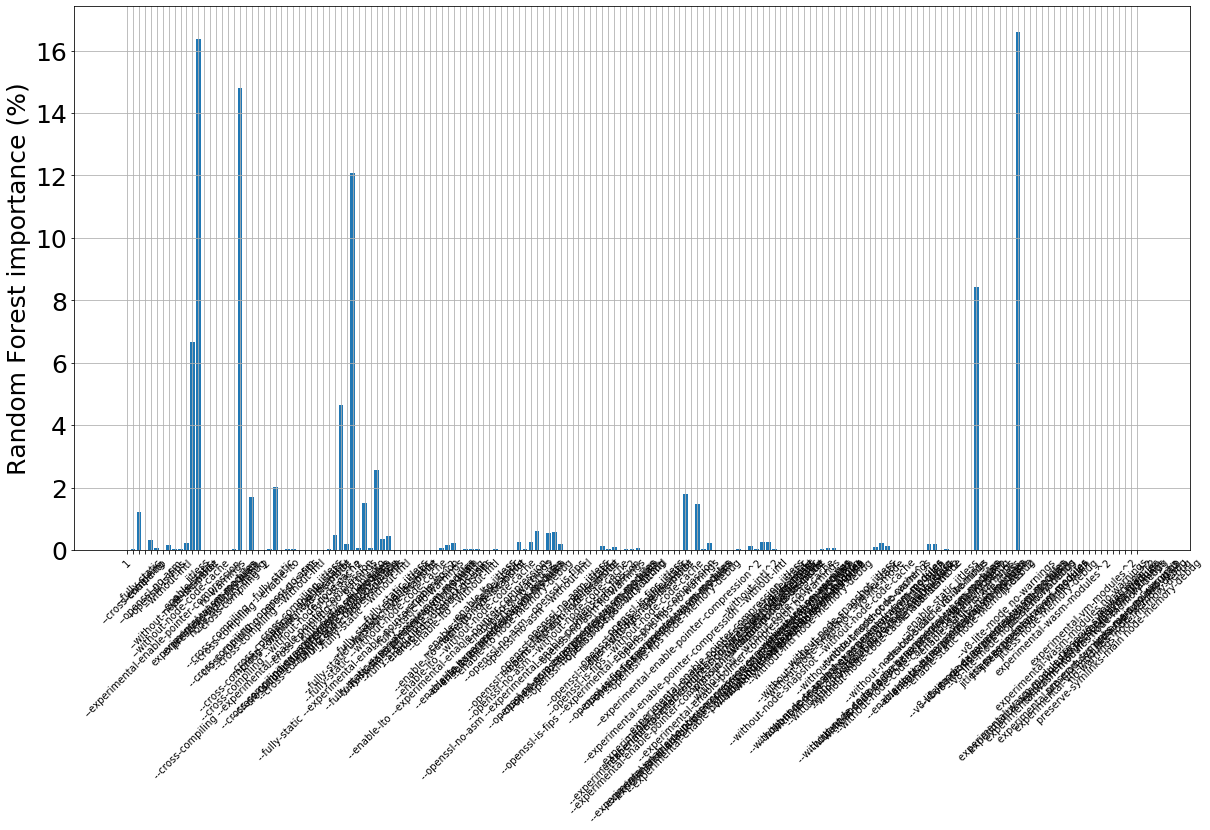

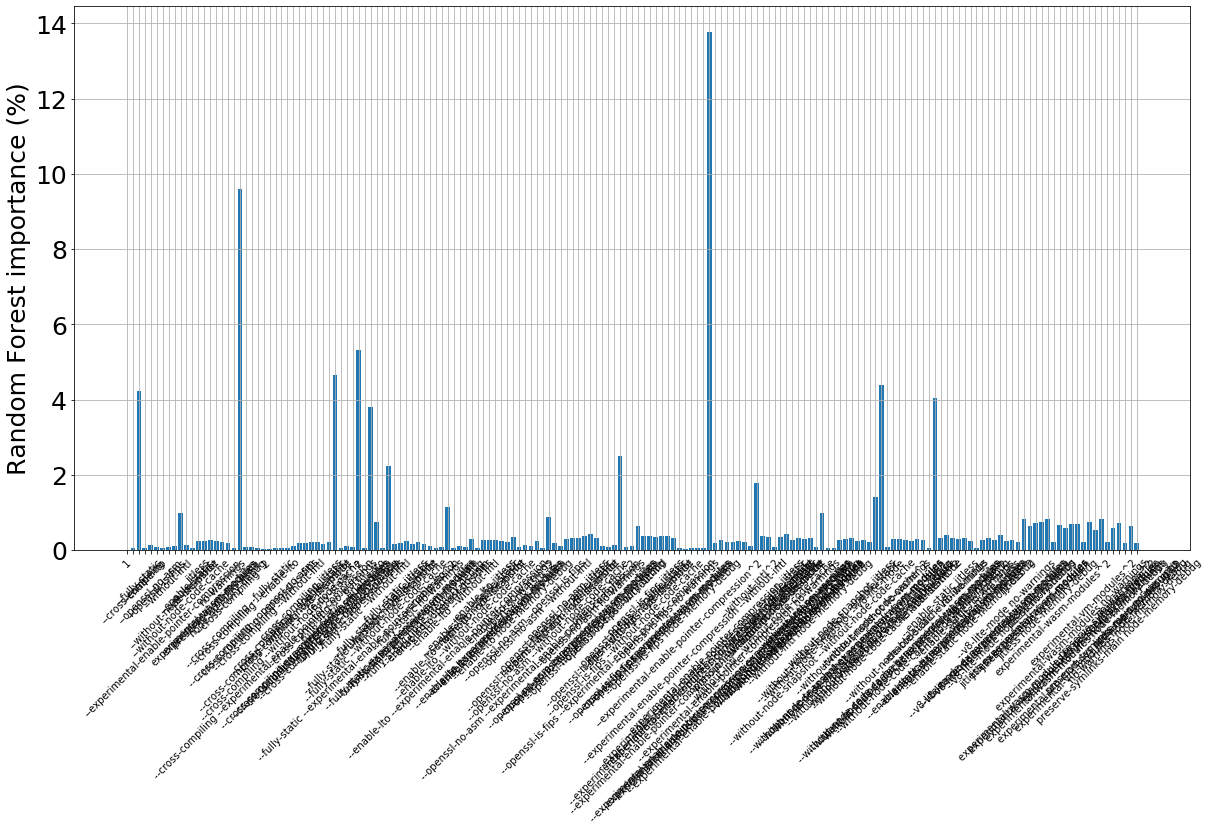

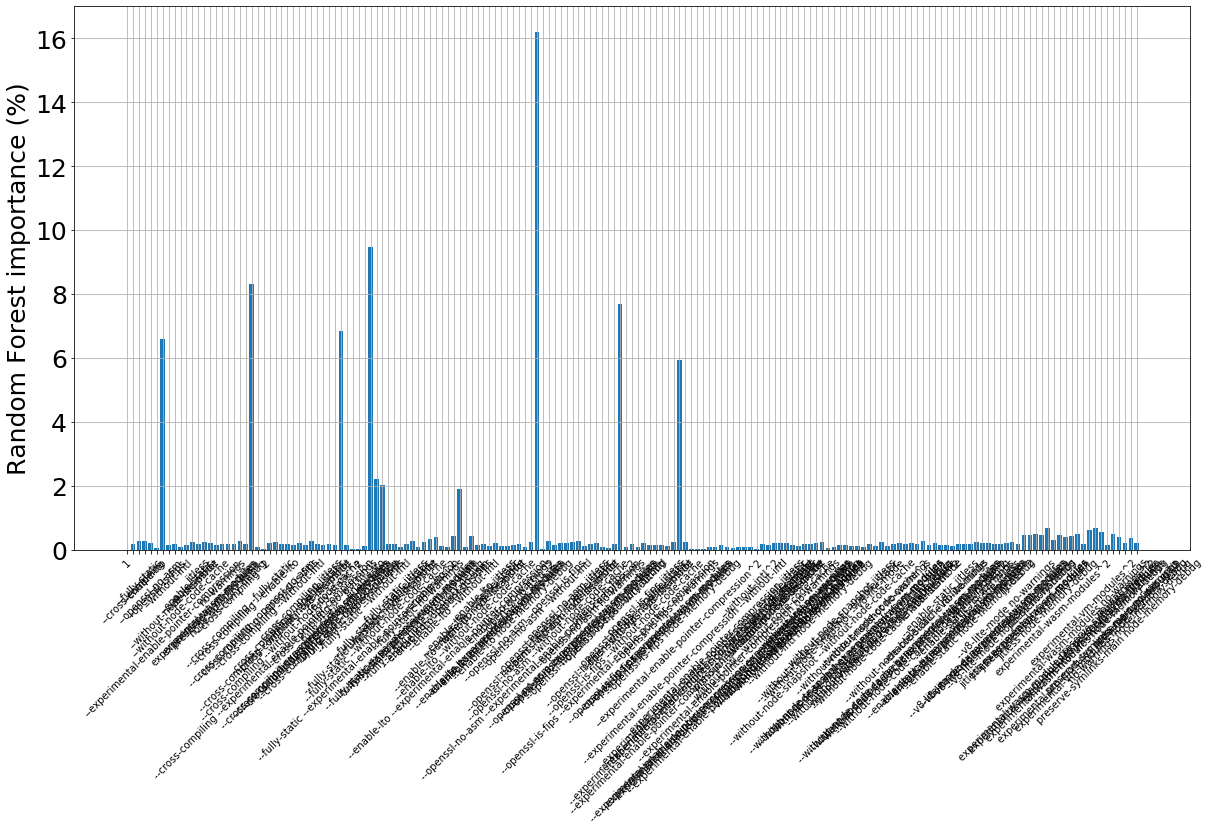

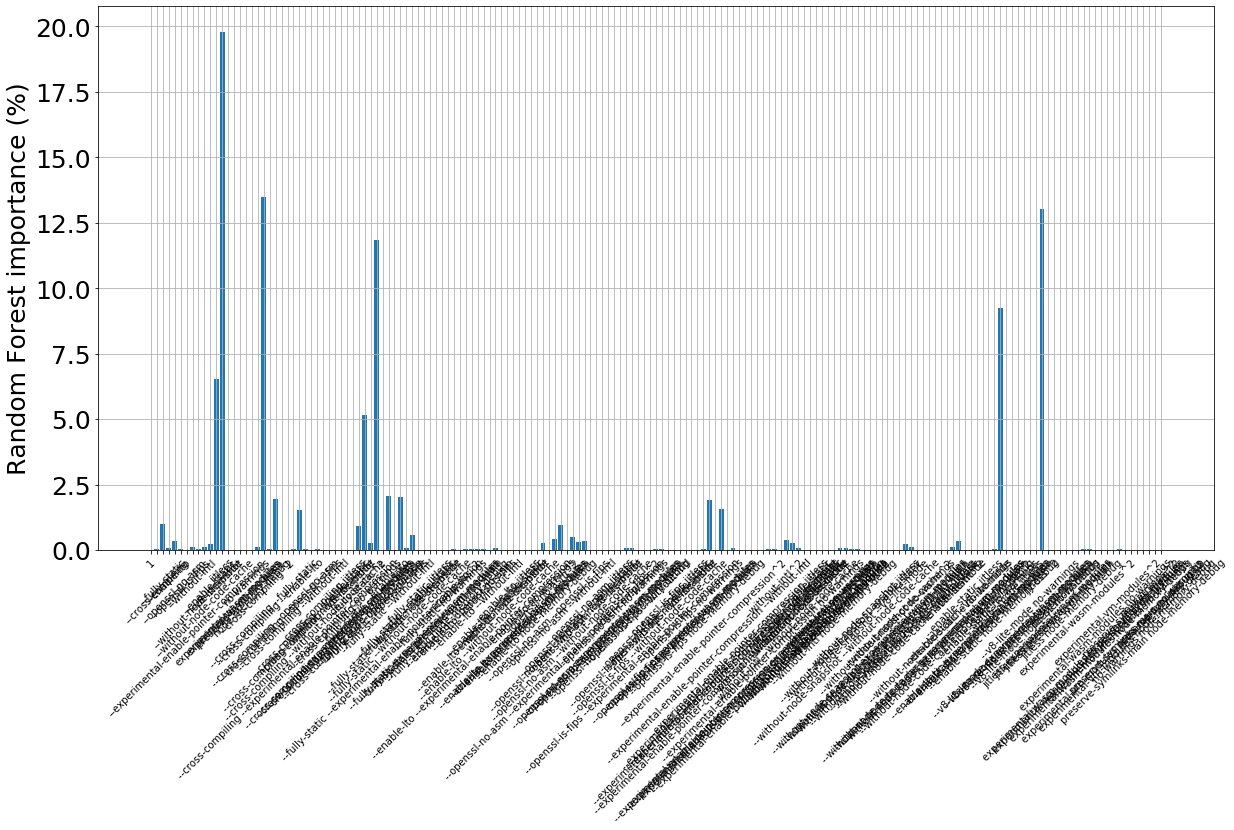

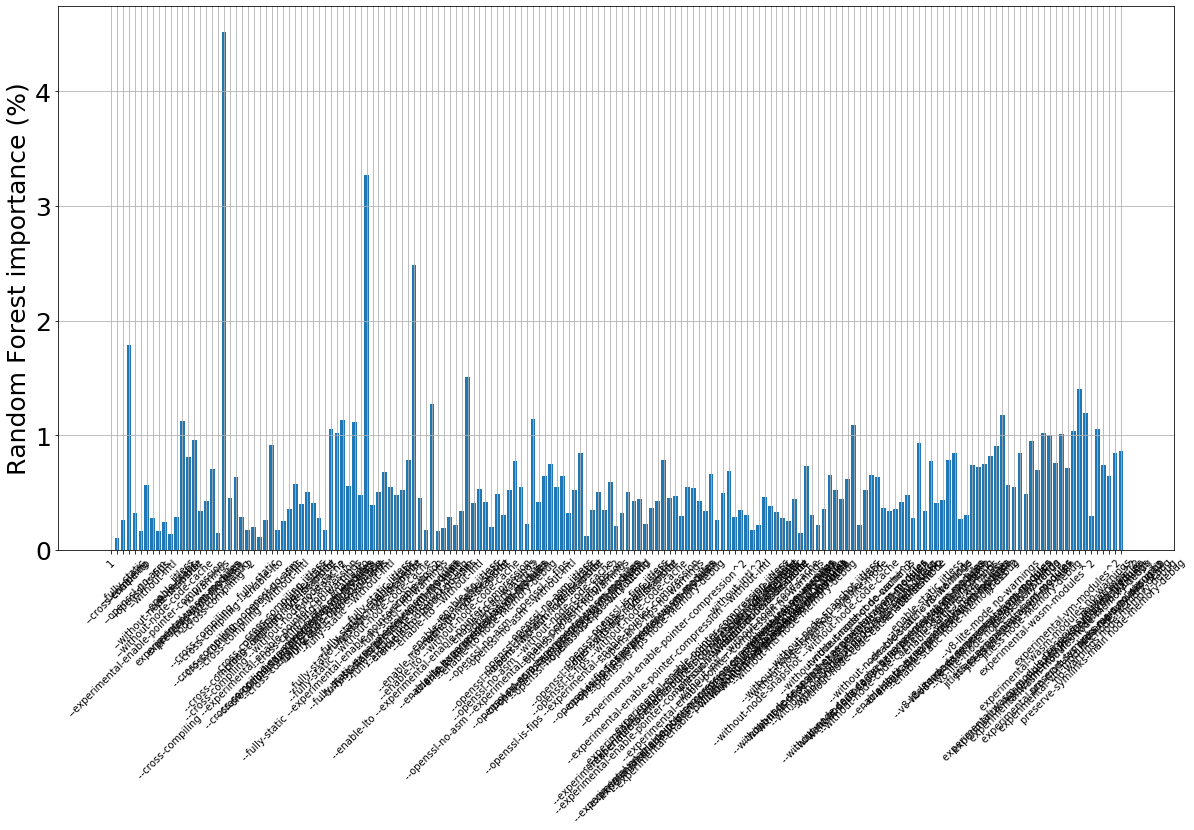

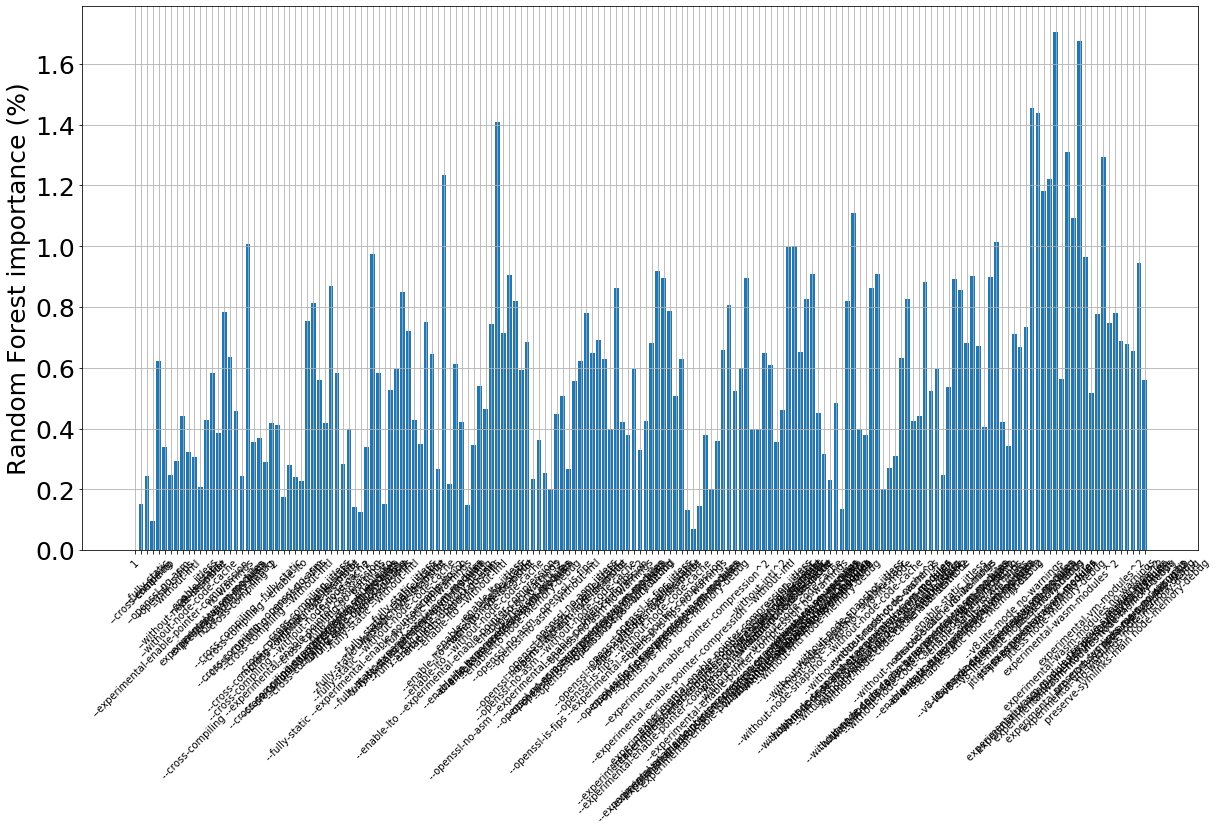

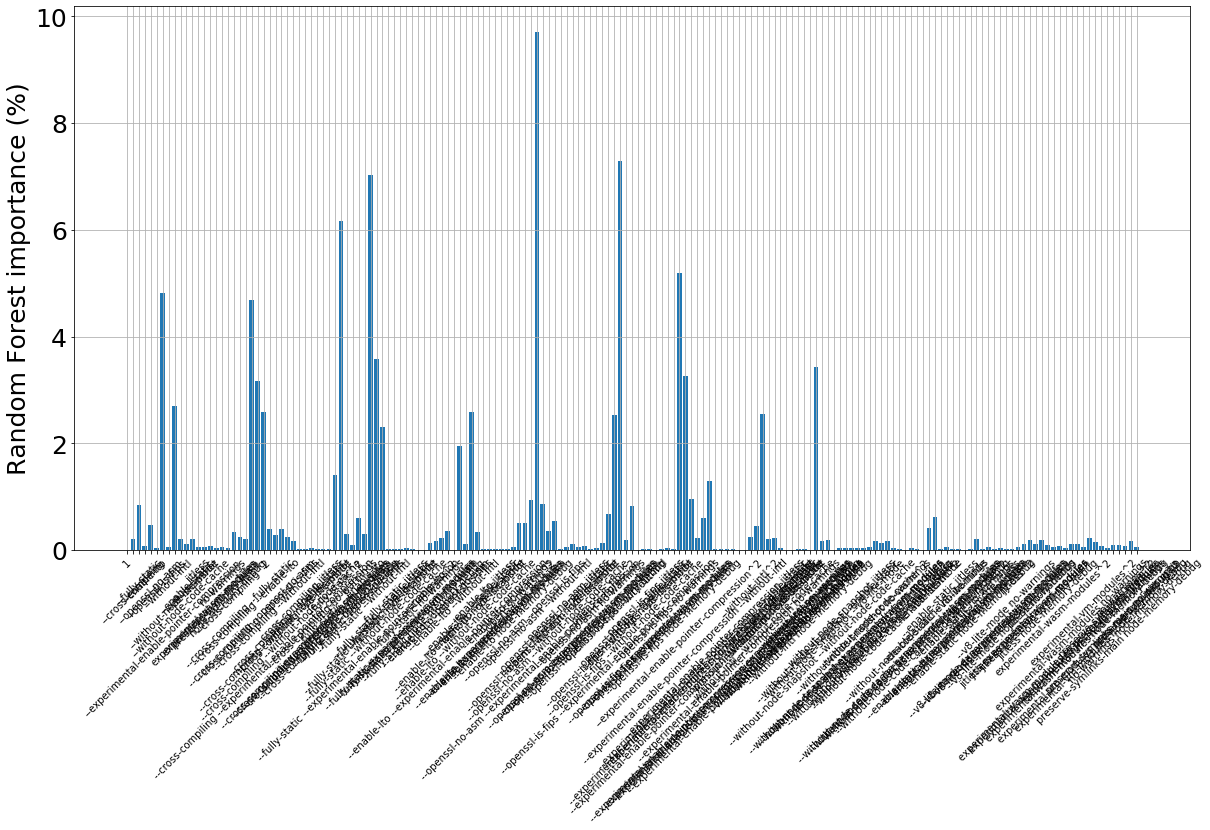

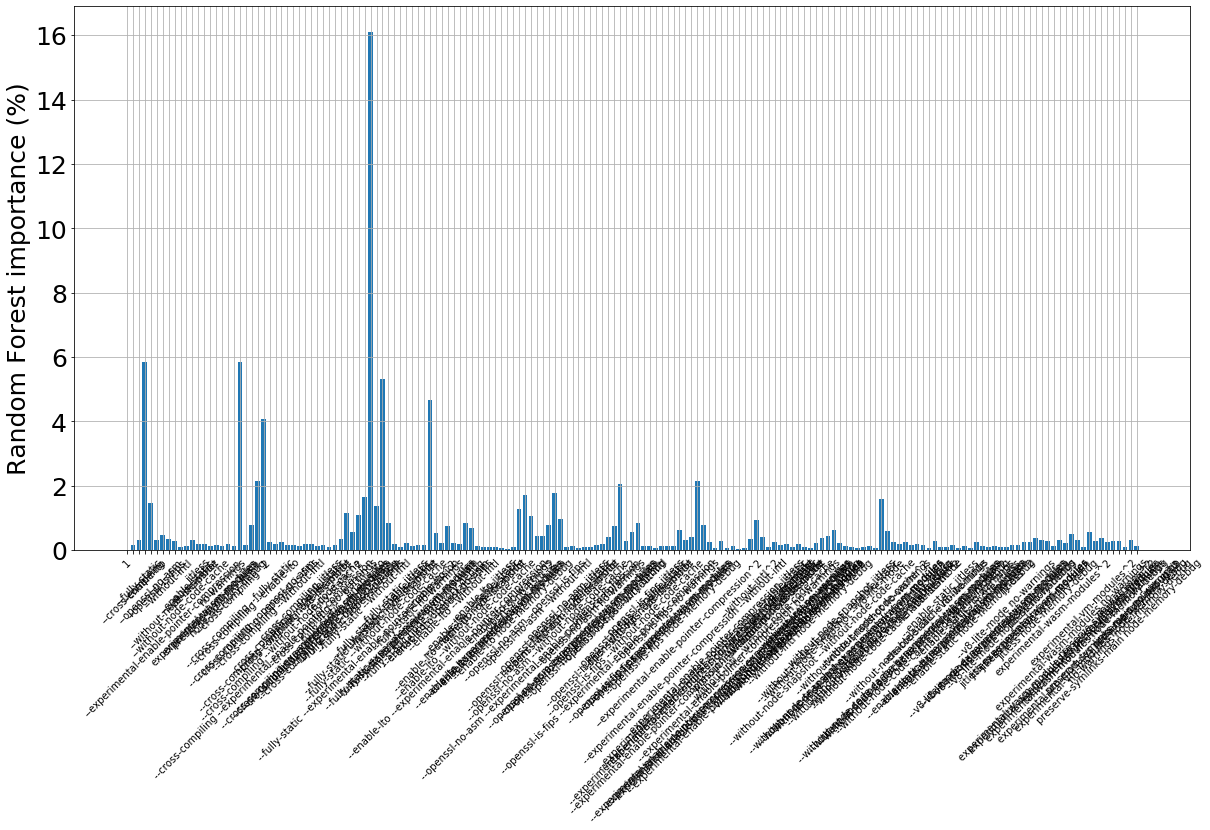

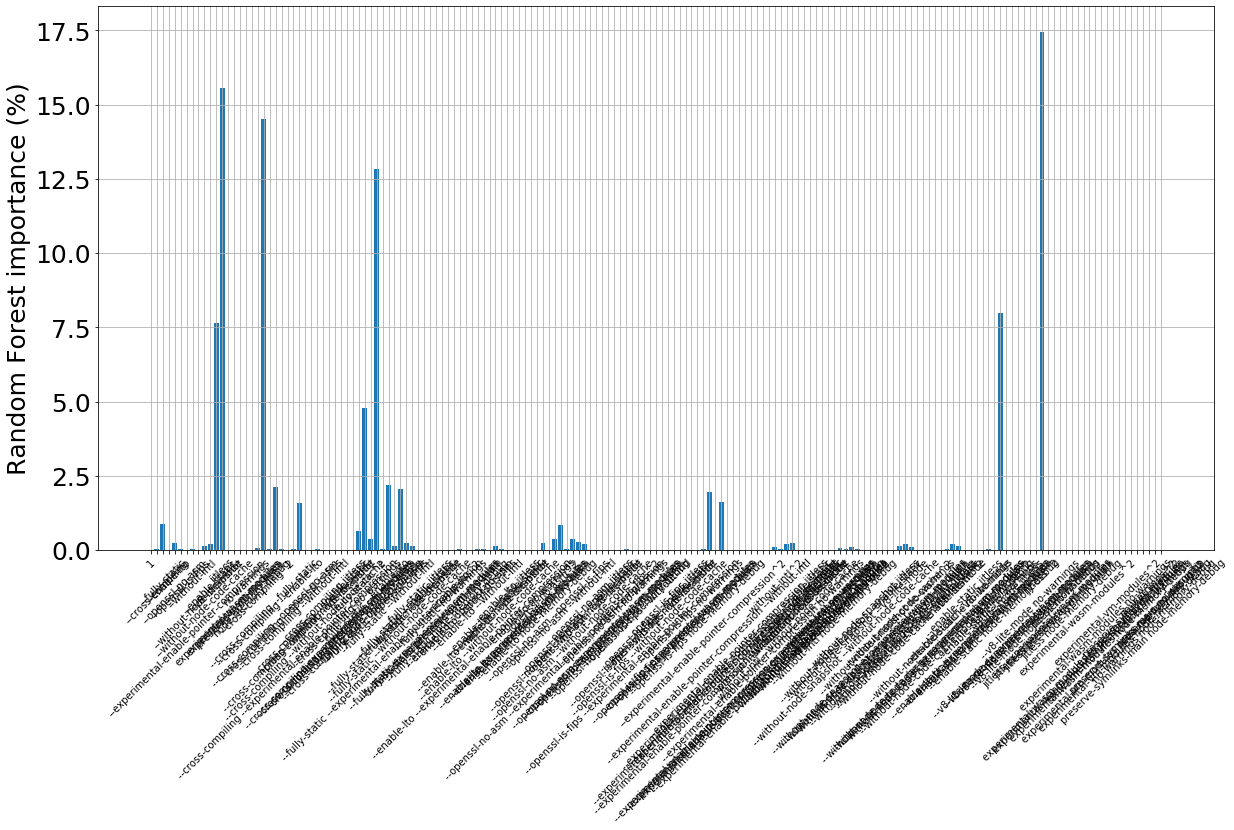

In [67]:
res_interact = dict()
for i in range(len(inputs_name["nodejs"])):
    res_interact[i+1]= show_imp_interact("nodejs", i, "ops")

In [96]:
res_interact[10].sort_values(ascending=True)[150:]

--openssl-no-asm^2                                                     0.002490
--openssl-no-asm --enable-static                                       0.002661
--fully-static --openssl-no-asm                                        0.003632
--openssl-no-asm --without-node-code-cache                             0.003647
--openssl-no-asm --experimental-enable-pointer-compression             0.003784
--fully-static^2                                                       0.006488
--openssl-no-asm --without-intl                                        0.008587
--fully-static                                                         0.008701
--cross-compiling --without-node-snapshot                              0.015842
--experimental-enable-pointer-compression --without-node-code-cache    0.016322
--experimental-enable-pointer-compression --without-intl               0.019613
--fully-static --without-node-code-cache                               0.020388
--cross-compiling --openssl-no-asm      

# RQ2.2

In [40]:
ns = "nodejs"
dim = "ops"

res_rq22 = dict()

# learning rates
lrs = [0.01, 0.05, 0.1]

for input_index in range(len(inputs_name[ns])):

    df = aggregate_data(ns, input_index, dim)

    perf_val = df.iloc[np.argmax(df[dim])][dim]

    val_default = default_data[ns, input_index][dim][0]

    res_rq22[input_index, "Oracle"] = perf_val/val_default
    
    print("Input="+str(input_index+1)+" : "+str(perf_val/val_default))

Input=1 : 1.0599309070713248
Input=2 : 1.09946844658139
Input=3 : 1.5045431351664464
Input=4 : 1.2505165944740293
Input=5 : 1.0069822499220096
Input=6 : 1.104064512317599
Input=7 : 0.9878912663316303
Input=8 : 1.054282891257011
Input=9 : 1.0391034905850076
Input=10 : 1.0443214896239967


In [41]:
for lr in lrs:
    
    for input_index in range(len(inputs_name[ns])):

        res_val = []
        res_val_def = []

        for i in range(10):

            df = aggregate_data(ns, input_index, dim)

            y = df[dim]
            X = df.drop([dim], axis=1)

            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = lr)

            rf = RandomForestRegressor()
            rf.fit(X_train, y_train)

            y_pred = rf.predict(X_test)

            if np.max(y_train) > np.max(y_pred):
                runtime_values = X_train.iloc[np.argmax(y_train)]
            else:
                runtime_values = X_test.iloc[np.argmax(y_pred)]

            perf_val = df.iloc[runtime_values.name][dim]

            res_default = default_data[ns, input_index]
            # [0] = default value, see the configuration csvs if you are not sure
            val_default = res_default[dim][0]
            val_mean = np.mean(res_default[dim])

            #res_default.columns = ['val'+str(k) for k in range(len(res_default.columns))]
            #for i in range(1,len(res_default.columns)-1):
            #    query_feature = "val"+str(i)+"=="+str(runtime_values[10+i])
            #    res_default = res_default.query(query_feature)


            res_val.append(perf_val/val_mean)
            res_val_def.append(perf_val/val_default)

        #print("Input " + str(input_index) +" : "+ str(np.mean(res_val)))
        res_rq22[input_index, str(lr)] = np.mean(res_val_def)

In [42]:
lrs2 = [str(lr) for lr in lrs]
lrs2.append("Oracle")
print("\\begin{table}[htb]")
print("\\begin{tabular}{|c|c|c|c|c|}")
print("\\hline")
print("Training Size")
for lr in lrs2:
    print("& "+lr)
print("\\\\ \\hline")
for input_index in range(10):
    print("$\mathcal{I}$\\#"+str(input_index+1))
    for lr in lrs2:
        print("& "+str(np.round(res_rq22[input_index,lr],3)))
    print("\\\\ \\hline")
print("\\end{tabular}")
print("\\label{tab:cross-tuning}")
print("\\caption{Performance ratios between the best predicted configuration and the default configuration}")
print("\\end{table}")

\begin{table}[htb]
\begin{tabular}{|c|c|c|c|c|}
\hline
Training Size
& 0.01
& 0.05
& 0.1
& Oracle
\\ \hline
$\mathcal{I}$\#1
& 0.929
& 1.039
& 1.038
& 1.06
\\ \hline
$\mathcal{I}$\#2
& 1.068
& 1.086
& 1.093
& 1.099
\\ \hline
$\mathcal{I}$\#3
& 1.184
& 1.372
& 1.404
& 1.505
\\ \hline
$\mathcal{I}$\#4
& 1.105
& 1.208
& 1.226
& 1.251
\\ \hline
$\mathcal{I}$\#5
& 0.986
& 1.004
& 1.006
& 1.007
\\ \hline
$\mathcal{I}$\#6
& 0.982
& 1.058
& 1.089
& 1.104
\\ \hline
$\mathcal{I}$\#7
& 0.986
& 0.987
& 0.987
& 0.988
\\ \hline
$\mathcal{I}$\#8
& 1.038
& 1.046
& 1.05
& 1.054
\\ \hline
$\mathcal{I}$\#9
& 1.036
& 1.037
& 1.038
& 1.039
\\ \hline
$\mathcal{I}$\#10
& 0.997
& 1.023
& 1.025
& 1.044
\\ \hline
\end{tabular}
\label{tab:cross-tuning}
\caption{Performance ratios between the best predicted configuration and the default configuration}
\end{table}
